In [1]:
import os
import pandas as pd
from tqdm import tqdm
from datetime import timedelta
import requests
from zipfile import ZipFile
import numpy as np
import shutil

# Step 1

def download_and_extract(zip_urls, download_folder, extract_folder):
    """
    Downloads ZIP files from provided URLs and extracts their contents.
    """
    os.makedirs(download_folder, exist_ok=True)
    os.makedirs(extract_folder, exist_ok=True)
    
    for idx, url in enumerate(zip_urls):
        print(f"({idx + 1}/{len(zip_urls)}) Downloading: {url}")
        zip_filename = os.path.join(download_folder, os.path.basename(url))
        
        # Download the file
        with requests.get(url, stream=True) as response:
            response.raise_for_status()
            with open(zip_filename, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
        
        print(f"Downloaded: {zip_filename}")
        
        # Extract the ZIP file
        with ZipFile(zip_filename, 'r') as zip_ref:
            zip_ref.extractall(extract_folder)
            print(f"Extracted: {zip_filename} to {extract_folder}")

# Step 2

def process_large_csv(csv_files, temp_folder, chunk_size=100000):
    """Reads large CSV files and splits them into individual MMSI files efficiently."""
    os.makedirs(temp_folder, exist_ok=True)

    for csv_file in csv_files:
        print(f"Processing {csv_file}...")
        mmsi_file_handles = {}

        # Open file handles for each MMSI to append data directly to disk
        try:
            with tqdm(total=sum(1 for _ in open(csv_file)) - 1, desc="Processing chunks", unit="rows") as pbar:
                for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
                    # Filter out rows with 'Unknown value' in Navigational Status
                    chunk = chunk[chunk['Navigational status'] != 'Unknown value']

                    # Group by MMSI and write directly to files
                    for mmsi, group in chunk.groupby('MMSI'):
                        output_file = os.path.join(temp_folder, f"{mmsi}.csv")
                        if mmsi not in mmsi_file_handles:
                            # Open file in append mode if not already open
                            mmsi_file_handles[mmsi] = open(output_file, 'a', newline='')
                            # Write header if the file is new
                            group.to_csv(
                                mmsi_file_handles[mmsi],
                                index=False,
                                header=True,
                                mode='a'
                            )
                        else:
                            # Append without writing header
                            group.to_csv(
                                mmsi_file_handles[mmsi],
                                index=False,
                                header=False,
                                mode='a'
                            )

                    pbar.update(len(chunk))

        finally:
            # Ensure all file handles are closed
            for handle in mmsi_file_handles.values():
                handle.close()

    print("Processing complete.")

# step 2.2

def remove_duplicate_headers(folder, header_row=0):
    """
    Removes duplicate headers from all CSV files in a folder.

    Parameters:
        folder (str): Path to the folder containing the CSV files.
        header_row (int): Row number of the header (default is 0 for the first row).
    """
    for file in os.listdir(folder):
        if file.endswith('.csv'):
            file_path = os.path.join(folder, file)
            # print(f"Processing {file_path}...")
            
            try:
                # Read the CSV file
                df = pd.read_csv(file_path, header=header_row)
                
                # Identify and remove rows matching the header
                header = list(df.columns)
                df = df[df.apply(lambda row: list(row) != header, axis=1)]
                
                # Write the cleaned data back to the file
                df.to_csv(file_path, index=False)
            
            except Exception as e:
                print(f"Error processing {file}: {e}")

    print("Duplicate headers removed.")

def filter_by_area(input_folder, output_folder, area_bounds):
    """Filters MMSI files for entries within a specified geographical area."""
    os.makedirs(output_folder, exist_ok=True)
    min_lat, max_lat, min_lon, max_lon = area_bounds

    for file in tqdm(os.listdir(input_folder), desc="Filtering by area"):
        if not file.endswith('.csv'):
            continue
        df = pd.read_csv(os.path.join(input_folder, file))
        df = df[(df['Latitude'] >= min_lat) & (df['Latitude'] <= max_lat) & 
                (df['Longitude'] >= min_lon) & (df['Longitude'] <= max_lon)]
        if len(df) >= 10:  # Ensure at least 10 consecutive entries
            df.to_csv(os.path.join(output_folder, file), index=False)

def extract_time_sets(input_folder, output_folder, duration_minutes=30, tolerance_seconds=10):
    """Extracts time sets with consistent Navigational Status and saves each as a separate file with time range in the filename.
    Adds tolerance for duration of groups to account for small discrepancies (e.g., ±10 seconds).
    """
    os.makedirs(output_folder, exist_ok=True)

    for file in tqdm(os.listdir(input_folder), desc=f"Extracting {duration_minutes}-min sets"):
        if not file.endswith('.csv'):
            continue

        # Load the CSV file
        file_path = os.path.join(input_folder, file)
        try:
            df = pd.read_csv(file_path)

            # Strip leading and trailing spaces and remove the '#' from column names
            df.columns = df.columns.str.strip().str.lstrip('# ')
            print(f"Cleaned column names: {list(df.columns)}")

            # Ensure the 'Timestamp' column exists
            if 'Timestamp' not in df.columns:
                print(f"Error: 'Timestamp' column not found in {file}")
                continue

            # Convert the 'Timestamp' column to datetime
            try:
                df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
            except Exception as e:
                print(f"Error parsing 'Timestamp' in {file}: {e}")
                continue

            # Drop rows with invalid timestamps
            df = df.dropna(subset=['Timestamp'])

            # Skip files with only one entry
            if len(df) == 1:
                print(f"File '{file}' contains only one entry and will be skipped.")
                continue

            # Sort the DataFrame by timestamp
            df = df.sort_values('Timestamp')

            # Calculate the duration in minutes for each row and ensure it's consistent with the desired interval
            time_delta = pd.Timedelta(minutes=duration_minutes)

            # Calculate time groupings: we use the first timestamp to start the interval and group by durations
            df['Time_Group'] = ((df['Timestamp'] - df['Timestamp'].min()) // time_delta)

            grouped = df.groupby('Time_Group')

            valid_sets = 0
            for group_id, group in grouped:
                # Check if the Navigational Status is consistent
                if group['Navigational status'].nunique() == 1:
                    # Calculate the duration of the group
                    group_duration = group['Timestamp'].max() - group['Timestamp'].min()

                    # Calculate the expected duration in seconds
                    expected_duration_seconds = time_delta.total_seconds()

                    # Calculate the tolerance range (±10 seconds)
                    tolerance_range_min = expected_duration_seconds - tolerance_seconds
                    tolerance_range_max = expected_duration_seconds + tolerance_seconds
                    group_duration_seconds = group_duration.total_seconds()

                    # Skip groups that don't match the expected duration +/- tolerance
                    if not (tolerance_range_min <= group_duration_seconds <= tolerance_range_max):
                        print(f"File '{file}' has a group with a duration of {group_duration}. Skipping group {group_id}.")
                        continue

                    valid_sets += 1

                    # Get start and end times for the interval
                    start_time = group['Timestamp'].min().strftime('%Y%m%d_%H%M')
                    end_time = group['Timestamp'].max().strftime('%Y%m%d_%H%M')

                    # Construct the output filename with time range in the format: original_filename_starttime-endtime.csv
                    output_filename = f"{os.path.splitext(file)[0]}_{start_time}-{end_time}.csv"
                    output_path = os.path.join(output_folder, output_filename)

                    # Save the group as a separate file
                    group.to_csv(output_path, index=False)
                    print(f"Saved {duration_minutes}-min set: {output_filename}")

            if valid_sets == 0:
                print(f"No valid {duration_minutes}-min sets found in {file}.")

        except Exception as e:
            print(f"Error processing file {file}: {e}")

def analyze_navigational_status(input_folder):
    """Analyzes the distribution of 30-minute sets by Navigational Status."""
    status_counts = {}

    for file in tqdm(os.listdir(input_folder), desc="Analyzing Navigational Status"):
        if not file.endswith('.csv'):
            continue
        df = pd.read_csv(os.path.join(input_folder, file))
        status = df['Navigational status'].iloc[0]  # Assuming consistent status in each set
        status_counts[status] = status_counts.get(status, 0) + 1

    return status_counts

def filter_and_save_csv(input_folder: str, output_folder: str, columns_to_keep: list, row_filter: str = None):
    """
    Processes CSV files in the input folder, keeps only the specified columns,
    optionally applies row filtering, removes duplicate rows based on "Timestamp",
    and saves the filtered CSV files to the output folder.

    Parameters:
    - input_folder (str): Path to the folder containing input .csv files.
    - output_folder (str): Path to the folder where the filtered .csv files will be saved.
    - columns_to_keep (list): List of column names to retain.
    - row_filter (str, optional): A string representing a row filter condition, 
                                  e.g., 'SOG > 0'. Defaults to None (no row filtering).
    """
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)
    
    # List all the CSV files in the input folder
    csv_files = [f for f in os.listdir(input_folder) if f.endswith('.csv')]

    for file in csv_files:
        file_path = os.path.join(input_folder, file)
        
        # Read the CSV file
        df = pd.read_csv(file_path)
        
        # Remove duplicate rows based on the "Timestamp" column
        df = df.drop_duplicates(subset=["Timestamp"], keep="first")
        
        # Filter only the columns you need
        df_filtered = df[columns_to_keep]
        
        # Apply the row filtering condition if provided
        if row_filter:
            df_filtered = df_filtered.query(row_filter)
        
        # Save the filtered DataFrame to the output folder
        output_path = os.path.join(output_folder, f'filtered_{file}')
        df_filtered.to_csv(output_path, index=False)
        
        print(f"Processed {file} and saved to {output_path}")

def check_missing_values_in_csv(directory_path):
    # Loop through all CSV files in the specified directory
    for filename in os.listdir(directory_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(directory_path, filename)
            df = pd.read_csv(file_path)
            
            # Check for missing values in each column
            missing_data = df.isnull().sum()
            
            print(f"Missing values in {filename}:")
            print(missing_data)
            
            # Handle missing values:
            for column in df.columns:
                if missing_data[column] > 0:
                    # Suggestion for handling missing values
                    print(f"\nColumn: {column}")
                    if df[column].dtype in ['float64', 'int64']:
                        # Numeric columns: Suggest filling or interpolating
                        print(f"Suggested action: Interpolate missing values or fill with a default value (e.g., 0).")
                    else:
                        # Non-numeric columns (e.g., text): Suggest filling with the mode or dropping rows
                        print(f"Suggested action: Fill missing values with the most frequent value or drop rows.")
            
            print("\n")

def process_csv_files(input_folder):
    """
    Processes CSV files in a given folder to handle missing numerical values.

    Parameters:
    input_folder (str): Path to the folder containing CSV files.

    Returns:
    dict: A dictionary with statistics about the processing.
    """
    # Counters for statistics
    files_deleted = 0
    files_with_interpolation = 0

    # Function to process a single CSV file
    def process_csv(file_path):
        nonlocal files_deleted, files_with_interpolation

        try:
            # Read the CSV file
            df = pd.read_csv(file_path, parse_dates=['Timestamp'])

            # Ensure numerical columns only
            numerical_columns = ['Latitude', 'Longitude', 'SOG', 'COG', 'Heading']
            for col in numerical_columns:
                if col not in df.columns:
                    raise ValueError(f"Missing expected column: {col}")

            # Check for columns with all missing values
            for col in numerical_columns:
                if df[col].isnull().all():
                    print(f"File {file_path} has an entire column '{col}' with missing values. Deleting file.")
                    os.remove(file_path)
                    files_deleted += 1
                    return

            # Calculate missing values per row in numerical columns
            df['missing_values_count'] = df[numerical_columns].isnull().sum(axis=1)

            # Check for rows with more than 50% missing numerical values
            if (df['missing_values_count'] > len(numerical_columns) / 2).any():
                print(f"File {file_path} has rows with >50% missing values. Deleting file.")
                os.remove(file_path)
                files_deleted += 1
                return

            # Check if any interpolation is needed
            if df[numerical_columns].isnull().any().any():
                print(f"File {file_path} requires interpolation.")
                files_with_interpolation += 1

            # Ensure Timestamp column is properly parsed and set as the index
            df['Timestamp'] = pd.to_datetime(df['Timestamp'])
            df = df.set_index('Timestamp')

            # Interpolate missing values based on the timestamp
            df[numerical_columns] = df[numerical_columns].interpolate(
                method='time', limit_direction='both', axis=0
            )

            # Reset the index after interpolation
            df = df.reset_index()

            # Drop the helper column
            df = df.drop(columns=['missing_values_count'])

            # Overwrite the original file
            df.to_csv(file_path, index=False)
            print(f"File {file_path} has been updated.")

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

    # Iterate over all files in the folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".csv"):
            file_path = os.path.join(input_folder, filename)
            process_csv(file_path)

    # Final check for missing values in all processed files
    missing_values_found = False
    for filename in os.listdir(input_folder):
        if filename.endswith(".csv"):
            file_path = os.path.join(input_folder, filename)
            df = pd.read_csv(file_path)
            if df.isnull().any().any():
                print(f"File {file_path} still contains missing values!")
                missing_values_found = True

    if not missing_values_found:
        print("No missing values found in any processed files.")

    # Return statistics
    return {
        "files_deleted": files_deleted,
        "files_with_interpolation": files_with_interpolation,
        "missing_values_remaining": missing_values_found
    }

# Function to standardize the time intervals in each CSV file
def standardize_time_intervals(file_path, interval_seconds=10, output_folder="standardized_files"):
    # Step 1: Read the CSV file
    df = pd.read_csv(file_path)
    
    # Step 2: Convert the 'Timestamp' column to datetime format
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Step 3: Generate a regular time range starting from the first timestamp to the last
    start_time = df['Timestamp'].min()
    end_time = df['Timestamp'].max()
    
    # Create a new time index with the specified interval (e.g., every 10 seconds)
    new_time_index = pd.date_range(start=start_time, end=end_time, freq=f'{interval_seconds}s')
    
    # Step 4: Interpolate the data for each numerical column
    df.set_index('Timestamp', inplace=True)
    
    # Reindex the dataframe to the new time index and interpolate missing numerical values
    df_resampled = df.reindex(new_time_index)

    # Interpolate only numerical columns
    numerical_columns = df.select_dtypes(include=[np.number]).columns
    df_resampled[numerical_columns] = df_resampled[numerical_columns].interpolate(method='linear')

    # For non-numerical columns (like 'Navigational Status'), we fill the missing values by forward filling (ffill)
    df_resampled['Navigational status'] = df_resampled['Navigational status'].ffill()

    # Reset index to have Timestamp as a column again
    df_resampled.reset_index(inplace=True)
    df_resampled.rename(columns={'index': 'Timestamp'}, inplace=True)
    
    # Step 5: Ensure output folder exists, create if it doesn't
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Generate the output file path
    output_path = os.path.join(output_folder, file_path.split(os.sep)[-1].replace('.csv', f'_standardized_{interval_seconds}s.csv'))
    
    # Step 6: Save the result to a new CSV file in the output folder
    df_resampled.to_csv(output_path, index=False)
    print(f"Standardized file saved to {output_path}")

# Step 11: Function to process each CSV file
def process_csv_step11(file_path, output_path):
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Remove the specified columns
    columns_to_remove = ['MMSI', 'Latitude', 'Longitude']
    df = df.drop(columns=columns_to_remove, errors='ignore')
    
    # Check if 'COG' and 'Heading' columns exist and subtract the first value of 'COG' from both columns
    if 'COG' in df.columns and 'Heading' in df.columns:
        first_cog = df['COG'].iloc[0]
        
        # Subtract the first 'COG' value from all 'COG' and 'Heading' values, ensuring the 0-360 format
        def adjust_angle(x, first_cog_value):
            diff = x - first_cog_value
            return (diff + 360) % 360
    
        df['COG'] = df['COG'].apply(lambda x: adjust_angle(x, first_cog))
        df['Heading'] = df['Heading'].apply(lambda x: adjust_angle(x, first_cog))
          
    # Save the modified DataFrame to the new folder
    df.to_csv(output_path, index=False)
    # print(f"Processed file saved to: {output_path}")

# Step 12: Speed threshold
def check_and_move_files(folder_1, folder_2, dest_folder_1, dest_folder_2, sog_threshold_fishing, sog_threshold_underway):
    # Ensure the destination folders exist, create them if not
    os.makedirs(dest_folder_1, exist_ok=True)
    os.makedirs(dest_folder_2, exist_ok=True)

    # Step 1: Get all CSV files in the two specified folders
    csv_files_1 = [f for f in os.listdir(folder_1) if f.endswith('.csv')]
    csv_files_2 = [f for f in os.listdir(folder_2) if f.endswith('.csv')]

    # Function to check conditions and move files for a given folder
    def process_files_in_folder(folder, dest_folder, sog_threshold_fishing, sog_threshold_underway):
        for csv_file in os.listdir(folder):
            if csv_file.endswith('.csv'):
                file_path = os.path.join(folder, csv_file)
                try:
                    df = pd.read_csv(file_path)

                    # Case 1: Check for "Engaged in fishing" and mean SOG > sog_threshold_fishing
                    fishing_condition = (df['Navigational status'] == 'Engaged in fishing')
                    mean_sog = df['SOG'].mean()
                    
                    # Case 2: Check for "Underway using engine" and any SOG > sog_threshold_underway
                    underway_condition = (df['Navigational status'] == 'Underway using engine')
                    sog_above_threshold = df['SOG'] > sog_threshold_underway
                    
                    # If any condition is met, move the file
                    if (fishing_condition.any() and mean_sog > sog_threshold_fishing) or \
                       (underway_condition.any() and sog_above_threshold.any()):
                        shutil.move(file_path, os.path.join(dest_folder, csv_file))
                        print(f"Moved {csv_file} from {folder} to {dest_folder}")

                except Exception as e:
                    print(f"Failed to process {csv_file} in {folder}: {e}")

    # Process files in both folders
    process_files_in_folder(folder_1, dest_folder_1, sog_threshold_fishing, sog_threshold_underway)
    process_files_in_folder(folder_2, dest_folder_2, sog_threshold_fishing, sog_threshold_underway)

def integrate_pipeline_with_web_sources(zip_urls, temp_folder, area_bounds):
    """
    Downloads and processes ZIP files, extracting CSVs and running the pipeline.
    """
    """# Step 1: Download and Extract
    # download_folder = './downloaded_zips'"""
    extract_folder = './extracted_files'    
    # download_and_extract(zip_urls, download_folder, extract_folder)

    # Step 2: Split CSVs into MMSI-specific files
    process_large_csv([os.path.join(extract_folder, f) for f in os.listdir(extract_folder) if f.endswith('.csv')], temp_folder)

    # Step 2.2
    folder_path = "mmsi_temp"
    remove_duplicate_headers(folder_path)

    # Step 3: Filter files by geographical area
    filtered_folder = './filtered_area'
    filter_by_area(temp_folder, filtered_folder, area_bounds)

    # Step 4: Extract time sets
    extract_time_sets(input_folder='./filtered_area', output_folder='./time_sets', duration_minutes=120, tolerance_seconds=30)

    # Step 5: Analyze Navigational Status
    sets_folder = './time_sets'
    status_distribution = analyze_navigational_status(sets_folder)
    print("Distribution of Navigational Status:", status_distribution)

    # Step 6: Slim the .csv files down to what we want to work with
    input_folder = './time_sets'
    output_folder = './time_sets_slim'

    # Columns you want to retain in the filtered CSVs
    columns_to_keep = [
        'Timestamp', 'MMSI', 'Latitude', 'Longitude', 
        'Navigational status', 'SOG', 'COG', 'Heading'
    ]

    # Optionally define a row filter (e.g., remove rows with SOG <= 0)
    # row_filter = 'SOG > 0'  # Optional, can be set to None if no filtering is needed

    # Call the function
    filter_and_save_csv(input_folder, output_folder, columns_to_keep)

    # Step 7: Getting overview of missing values in the slimmed sets
    directory_path = "./time_sets_slim"
    check_missing_values_in_csv(directory_path)

    # Step 8: Imputing and deleting
    input_folder = "./time_sets_slim"
    process_csv_files(input_folder)

    # Step 9: Analyze Navigational Status again
    sets_folder = './time_sets_slim'
    status_distribution = analyze_navigational_status(sets_folder)
    print("Distribution of Navigational Status:", status_distribution)

    # Step 10: standardize to specified interval in files
    folder_path = 'time_sets_slim'
    output_folder = 'time_sets_standardized'

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            standardize_time_intervals(file_path, interval_seconds=60, output_folder=output_folder)  # Adjust interval as needed
    
    # Step 11: cut down to what we would have in radar and zeroed course
    # Define the input and output folders
    input_folder = 'time_sets_standardized'  # Replace with your folder containing CSV files
    output_folder = 'time_sets_st_shortened'
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    # Iterate through all CSV files in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith('.csv'):
            input_file = os.path.join(input_folder, filename)
            output_file = os.path.join(output_folder, filename)
            
            # Process each CSV file
            process_csv_step11(input_file, output_file)
    
    # Step 12: Speed thresholds
    folder_1 = 'time_sets_standardized'
    folder_2 = 'time_sets_st_shortened'
    dest_folder_1 = 'time_sets_standardized_out'
    dest_folder_2 = 'time_sets_st_shortened_out'

    sog_threshold_fishing = 10.0  # Example threshold for "Engaged in fishing" scenario
    sog_threshold_underway = 30.0  # Example threshold for "Underway using engine" scenario

    check_and_move_files(folder_1, folder_2, dest_folder_1, dest_folder_2, sog_threshold_fishing, sog_threshold_underway)
    


# Example URLs for ZIP files (replace with actual URLs)
zip_urls = [
    "https://web.ais.dk/aisdata/aisdk-2024-05-24.zip",
    "https://web.ais.dk/aisdata/aisdk-2024-05-23.zip",
    "https://web.ais.dk/aisdata/aisdk-2024-05-22.zip"
]

# Example usage
area_bounds = (55.0, 56.0, 7.0, 8.0)  # Define your area
temp_folder = './mmsi_temp'
integrate_pipeline_with_web_sources(zip_urls, temp_folder, area_bounds)


Processing ./extracted_files\aisdk-2024-06-01.csv...


Processing chunks:  77%|███████▋  | 19184957/24936822 [06:49<02:02, 46804.61rows/s]


Processing ./extracted_files\aisdk-2024-06-02.csv...


Processing chunks:  78%|███████▊  | 19462097/24869593 [07:21<02:02, 44050.99rows/s]


Processing ./extracted_files\aisdk-2024-06-03.csv...


Processing chunks:  81%|████████  | 16060536/19826255 [05:44<01:20, 46599.96rows/s]


Processing ./extracted_files\aisdk-2024-06-04.csv...


Processing chunks:  79%|███████▉  | 15592620/19651306 [05:31<01:26, 47014.96rows/s]


Processing ./extracted_files\aisdk-2024-06-05.csv...


Processing chunks:  80%|████████  | 13844977/17239519 [04:47<01:10, 48138.52rows/s]


Processing ./extracted_files\aisdk-2024-06-06.csv...


Processing chunks:  80%|███████▉  | 13952737/17518034 [04:49<01:13, 48226.36rows/s]


Processing ./extracted_files\aisdk-2024-06-07.csv...


Processing chunks:  78%|███████▊  | 13987414/17895826 [04:51<01:21, 48032.80rows/s]


Processing ./extracted_files\aisdk-2024-06-08.csv...


Processing chunks:  80%|███████▉  | 14329854/18022876 [05:05<01:18, 46851.74rows/s]


Processing ./extracted_files\aisdk-2024-06-09.csv...


Processing chunks:  81%|████████  | 13510113/16759631 [04:36<01:06, 48801.49rows/s]


Processing ./extracted_files\aisdk-2024-06-10.csv...


Processing chunks:  79%|███████▉  | 13626548/17232720 [04:49<01:16, 47111.71rows/s]


Processing ./extracted_files\aisdk-2024-06-11.csv...


Processing chunks:  79%|███████▊  | 13908334/17715116 [04:50<01:19, 47956.07rows/s]


Processing ./extracted_files\aisdk-2024-06-12.csv...


Processing chunks:  79%|███████▉  | 13741855/17344217 [04:46<01:15, 47964.16rows/s]


Processing ./extracted_files\aisdk-2024-06-13.csv...


Processing chunks:  79%|███████▉  | 14488251/18267806 [05:06<01:19, 47274.17rows/s]


Processing ./extracted_files\aisdk-2024-06-14.csv...


Processing chunks:  79%|███████▉  | 16802738/21310046 [06:00<01:36, 46555.10rows/s]


Processing ./extracted_files\aisdk-2024-06-15.csv...


Processing chunks:  80%|███████▉  | 15389768/19279718 [05:25<01:22, 47340.07rows/s]


Processing ./extracted_files\aisdk-2024-06-16.csv...


Processing chunks:  77%|███████▋  | 17150740/22137850 [06:28<01:53, 44123.07rows/s]


Processing ./extracted_files\aisdk-2024-06-17.csv...


Processing chunks:  78%|███████▊  | 16209899/20785650 [05:52<01:39, 45952.32rows/s]


Processing ./extracted_files\aisdk-2024-06-18.csv...


Processing chunks:  78%|███████▊  | 15515957/19990733 [05:34<01:36, 46340.06rows/s]


Processing ./extracted_files\aisdk-2024-06-19.csv...


Processing chunks:  78%|███████▊  | 14536455/18536159 [05:06<01:24, 47470.81rows/s]


Processing ./extracted_files\aisdk-2024-06-20.csv...


Processing chunks:  79%|███████▊  | 16662763/21210860 [06:12<01:41, 44675.82rows/s]


Processing ./extracted_files\aisdk-2024-06-21.csv...


Processing chunks:  79%|███████▊  | 19610368/24967115 [07:25<02:01, 44018.40rows/s]


Processing ./extracted_files\aisdk-2024-06-22.csv...


Processing chunks:  78%|███████▊  | 14788926/18877433 [05:25<01:29, 45438.52rows/s]


Processing ./extracted_files\aisdk-2024-06-23.csv...


Processing chunks:  77%|███████▋  | 15748696/20496876 [05:45<01:44, 45527.19rows/s]


Processing ./extracted_files\aisdk-2024-06-24.csv...


Processing chunks:  77%|███████▋  | 17658713/22998072 [06:49<02:03, 43106.62rows/s]


Processing ./extracted_files\aisdk-2024-06-25.csv...


Processing chunks:  78%|███████▊  | 23202803/29727356 [09:11<02:34, 42103.15rows/s]


Processing ./extracted_files\aisdk-2024-06-26.csv...


Processing chunks:  77%|███████▋  | 21001240/27140311 [08:07<02:22, 43081.77rows/s]


Processing ./extracted_files\aisdk-2024-06-27.csv...


Processing chunks:  78%|███████▊  | 20572416/26474348 [07:45<02:13, 44181.13rows/s]


Processing ./extracted_files\aisdk-2024-06-28.csv...


Processing chunks:  78%|███████▊  | 16958575/21684313 [06:14<01:44, 45322.97rows/s]


Processing ./extracted_files\aisdk-2024-06-29.csv...


Processing chunks:  75%|███████▌  | 15709415/20897511 [05:40<01:52, 46153.77rows/s]


Processing ./extracted_files\aisdk-2024-06-30.csv...


Processing chunks:  76%|███████▋  | 14862782/19431925 [05:19<01:38, 46529.86rows/s]


Processing complete.


C:\Users\goeck\AppData\Local\Temp\ipykernel_6900\1667968079.py:102: DtypeWarning: Columns (2,3,4,6,7,8,9,11,12,14,15,16,18,20,22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, header=header_row)
C:\Users\goeck\AppData\Local\Temp\ipykernel_6900\1667968079.py:102: DtypeWarning: Columns (2,3,4,6,7,8,9,10,15,16,18,22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, header=header_row)
C:\Users\goeck\AppData\Local\Temp\ipykernel_6900\1667968079.py:102: DtypeWarning: Columns (2,3,4,6,7,8,9,14,15,16,18,22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, header=header_row)
C:\Users\goeck\AppData\Local\Temp\ipykernel_6900\1667968079.py:102: DtypeWarning: Columns (2,3,4,6,7,8,9,10,14,15,16,18,22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_p

Duplicate headers removed.


Filtering by area:   0%|          | 9/8126 [00:01<23:26,  5.77it/s]C:\Users\goeck\AppData\Local\Temp\ipykernel_6900\1667968079.py:124: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(input_folder, file))
Filtering by area:   1%|          | 60/8126 [00:03<03:21, 40.04it/s]C:\Users\goeck\AppData\Local\Temp\ipykernel_6900\1667968079.py:124: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(input_folder, file))
Filtering by area:   1%|          | 75/8126 [00:06<11:40, 11.50it/s]C:\Users\goeck\AppData\Local\Temp\ipykernel_6900\1667968079.py:124: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(input_folder, file))
Filtering by area:   1%|▏         | 102/8126 [00:07<08:50, 15.12it/s]C:\Users\goeck\AppData\Local\Temp\ipykernel_6900\1667968079.py

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '111219515.csv' has a group with a duration of 0 days 01:55:54. Skipping group 0.
No valid 120-min sets found in 111219515.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 205453000_20240605_2349-20240606_0149.csv
File '205453000.csv' has a group with a duration of 0 days 00:32:20. Skipping group 1.
File '205453000.csv' has a group with a duration of 0 days 00:50:49. Skippi

Extracting 120-min sets:   1%|          | 5/515 [00:00<00:30, 16.77it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 205771000_20240620_0831-20240620_1031.csv
File '205771000.csv' has a group with a duration of 0 days 00:28:40. Skipping group 1.
File '205771000.csv' has a group with a duration of 0 days 01:43:49. Skipping group 21.
File '205771000.csv' has a group with a duration of 0 days 00:30:24. Skipping group 22.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '209207000.csv' has a group

Extracting 120-min sets:   2%|▏         | 9/515 [00:00<00:26, 19.08it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '209583000.csv' has a group with a duration of 0 days 01:18:19. Skipping group 0.
File '209583000.csv' has a group with a duration of 0 days 00:01:40. Skipping group 34.
File '209583000.csv' has a group with a duration of 0 days 01:22:50. Skipping group 35.
File '209583000.csv' has a group with a duration of 0 days 00:27:20. Skipping group 145.
Saved 120-min set: 209583000_20240615_1250-20240615_1450.csv
File '209583000.csv' has a group with a duration of 0 days 00:42:50. Skipping group 147.
File '209583000.csv' has a group with a duration of 0 days 01:34:10. Skipping group 170.
File '209583000.csv' has a group with a duration of 0 days 01:26:51. Skipping group 171

Extracting 120-min sets:   2%|▏         | 12/515 [00:00<00:23, 21.55it/s]

Saved 120-min set: 209715000_20240628_1337-20240628_1537.csv
File '209715000.csv' has a group with a duration of 0 days 00:18:27. Skipping group 255.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 209734000_20240613_2131-20240613_2331.csv
Saved 120-min set: 209734000_20240613_2331-20240614_0131.csv
Saved 120-min set: 209734000_20240614_0131-20240614_0331.csv
File '209734000.csv' has a group with a duration of 0 days 00:31:01. Skipping group 3.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught'

Extracting 120-min sets:   3%|▎         | 18/515 [00:01<00:35, 13.95it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 210051000_20240601_1320-20240601_1520.csv
Saved 120-min set: 210051000_20240601_1520-20240601_1720.csv
Saved 120-min set: 210051000_20240601_1720-20240601_1920.csv
File '210051000.csv' has a group with a duration of 0 days 00:54:31. Skipping group 3.
File '210051000.csv' has a group with a duration of 0 days 01:33:01. Skipping group 48.
Saved 120-min set: 210051000_20240605_1521-20240605_1720.csv
File '210051000.csv' has a group with a duration of 0 days 00:22:21. Skipping group 50.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'S

Extracting 120-min sets:   5%|▍         | 24/515 [00:01<00:32, 15.12it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 210520000_20240621_0431-20240621_0631.csv
File '210520000.csv' has a group with a duration of 0 days 01:39:51. Skipping group 1.
File '210520000.csv' has a group with a duration of 0 days 01:36:54. Skipping group 8.
File '210520000.csv' has a group with a duration of 0 days 01:14:12. Skipping group 9.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '210548000.csv' has a group w

C:\Users\goeck\AppData\Local\Temp\ipykernel_6900\1667968079.py:143: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 211141000_20240601_0505-20240601_0705.csv
Saved 120-min set: 211141000_20240601_0705-20240601_0905.csv
File '211141000.csv' has a group with a duration of 0 days 00:03:25. Skipping group 2.
File '211141000.csv' has a group with a duration of 0 days 00:26:42. Skipping group 32.
Saved 120-min set: 211141000_20240603_2306-20240604_0105.csv
Saved 120-min set: 211141000_20240604_0106-20240604_0305.csv
File '211141000.csv' has a group with a duration of 0 days 00:06:12. Skipping group 35.
File '211141000.csv' has a group with a duration of 0 days 01:44:42. Skipping group 95.
Saved 120-min set: 211141000_20240609_0506-20240609_0705.csv
File '211141000.csv' h

Extracting 120-min sets:   5%|▌         | 27/515 [00:02<00:52,  9.28it/s]

Saved 120-min set: 211208720_20240630_0056-20240630_0256.csv
File '211208720.csv' has a group with a duration of 0 days 01:09:21. Skipping group 7.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 211211460_20240626_2152-20240626_2352.csv
File '211211460.csv' has a group with a duration of 0 days 00:48:33. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '211219630.csv' has a group with a duration of 0 days 0

Extracting 120-min sets:   6%|▌         | 29/515 [00:02<00:52,  9.25it/s]

Saved 120-min set: 211219630_20240627_0920-20240627_1120.csv
Saved 120-min set: 211219630_20240627_1120-20240627_1320.csv
File '211219630.csv' has a group with a duration of 0 days 01:58:30. Skipping group 150.
File '211219630.csv' has a group with a duration of 0 days 01:27:41. Skipping group 151.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 211230400_20240625_0412-20240625_0612.csv
Saved 120-min set: 211230400_20240625_0612-20240625_0812.csv
File '211230400.csv' has a group with a duration of 0 days 00:20:19. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 

Extracting 120-min sets:   6%|▋         | 33/515 [00:02<00:38, 12.56it/s]

Saved 120-min set: 211341960_20240624_2336-20240625_0136.csv
File '211341960.csv' has a group with a duration of 0 days 01:30:40. Skipping group 1.
File '211341960.csv' has a group with a duration of 0 days 00:49:10. Skipping group 7.
Saved 120-min set: 211341960_20240625_1536-20240625_1736.csv
File '211341960.csv' has a group with a duration of 0 days 00:02:19. Skipping group 9.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 211417590_20240628_1057-20240628_1256.csv
Saved 120-min set: 211417590_20240628_1257-20240628_1456.csv
Saved 120-min set: 211417590_20240628_1457-20240628_1656.csv
Saved 120-min set: 211417590_20240628_1657-20240628_1856.csv
File '211417590.csv' has a group with a duration of

Extracting 120-min sets:   7%|▋         | 38/515 [00:03<00:44, 10.71it/s]

Saved 120-min set: 211417590_20240630_0457-20240630_0657.csv
Saved 120-min set: 211417590_20240630_0657-20240630_0857.csv
File '211417590.csv' has a group with a duration of 0 days 00:00:00. Skipping group 23.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '211436320.csv' has a group with a duration of 0 days 01:56:50. Skipping group 0.
File '211436320.csv' has a group with a duration of 0 days 01:59:01. Skipping group 1.
Saved 120-min set: 211436320_20240625_0516-20240625_0716.csv
File '211436320.csv' has a group with a duration of 0 days 01:57:01. Skipping group 4.
File '211436320.csv' has a group with a duration of 0 days 01:57:04. Skipping group 5.
File '211436320.csv' has a group with a duration of 0 days 

Extracting 120-min sets:   8%|▊         | 43/515 [00:03<00:30, 15.34it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '211845000.csv' has a group with a duration of 0 days 01:15:02. Skipping group 0.
File '211845000.csv' has a group with a duration of 0 days 00:20:54. Skipping group 56.
File '211845000.csv' has a group with a duration of 0 days 00:55:19. Skipping group 57.
File '211845000.csv' has a group with a duration of 0 days 01:00:43. Skipping group 116.
File '211845000.csv' has a group with a duration of 0 days 00:29:42. Skipping group 117.
File '211845000.csv' has a group with a duration of 0 days 00:40:54. Skipping group 157.
File '211845000.csv' has a group with a duration of 0 days 00:00:54. Skipping group 158.
File '211845000.csv' has a group with a duration of 0 days 

Extracting 120-min sets:   9%|▉         | 46/515 [00:03<00:27, 16.99it/s]

Saved 120-min set: 211927000_20240629_1255-20240629_1455.csv
File '211927000.csv' has a group with a duration of 0 days 01:28:50. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '212357000.csv' has a group with a duration of 0 days 00:06:49. Skipping group 0.
No valid 120-min sets found in 212357000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 212503000_20240609_1934-20240609_2134.csv
File '21250300

Extracting 120-min sets:  10%|▉         | 49/515 [00:03<00:31, 14.90it/s]

Saved 120-min set: 212613000_20240602_1155-20240602_1354.csv
File '212613000.csv' has a group with a duration of 0 days 01:36:00. Skipping group 1.
File '212613000.csv' has a group with a duration of 0 days 01:35:21. Skipping group 43.
Saved 120-min set: 212613000_20240606_0355-20240606_0554.csv
File '212613000.csv' has a group with a duration of 0 days 01:45:54. Skipping group 45.
File '212613000.csv' has a group with a duration of 0 days 00:21:43. Skipping group 90.
Saved 120-min set: 212613000_20240610_0155-20240610_0354.csv
File '212613000.csv' has a group with a duration of 0 days 01:59:18. Skipping group 92.
File '212613000.csv' has a group with a duration of 0 days 01:02:51. Skipping group 93.
File '212613000.csv' has a group with a duration of 0 days 01:44:31. Skipping group 132.
File '212613000.csv' has a group with a duration of 0 days 01:45:13. Skipping group 133.
File '212613000.csv' has a group with a duration of 0 days 00:11:25. Skipping group 202.
Saved 120-min set: 2126

Extracting 120-min sets:  10%|█         | 53/515 [00:04<00:31, 14.48it/s]

Saved 120-min set: 212878000_20240625_0111-20240625_0311.csv
File '212878000.csv' has a group with a duration of 0 days 01:15:40. Skipping group 1.
File '212878000.csv' has a group with a duration of 0 days 00:09:20. Skipping group 19.
Saved 120-min set: 212878000_20240626_1711-20240626_1911.csv
File '212878000.csv' has a group with a duration of 0 days 00:31:30. Skipping group 21.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 212949000_20240607_1108-20240607_1308.csv
File '212949000.csv' has a group with a duration of 0 days 01:29:23. Skipping group 1.
File '212949000.csv' has a group with a duration of 0 days 00:02:25. Skipping group 133.
File '212949000.csv' has a group with a duration of 0 da

Extracting 120-min sets:  11%|█         | 56/515 [00:04<00:37, 12.14it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 218098000_20240602_1405-20240602_1605.csv
Saved 120-min set: 218098000_20240602_1605-20240602_1805.csv
File '218098000.csv' has a group with a duration of 0 days 00:08:13. Skipping group 2.
File '218098000.csv' has a group with a duration of 0 days 01:03:24. Skipping group 79.
Saved 120-min set: 218098000_20240609_0605-20240609_0805.csv
File '218098000.csv' has a group with a duration of 0 days 01:01:00. Skipping group 81.
File '218098000.csv' has a group with a duration of 0 days 01:19:18. Skipping group 141.
Saved 120-min set: 218098000_20240614_1005-20240614_1205.csv
File '218098000.csv' has a group with a duration of 0 days 00:40:17. Skipping grou

Extracting 120-min sets:  11%|█▏        | 58/515 [00:04<00:36, 12.58it/s]

Saved 120-min set: 218176000_20240613_0312-20240613_0512.csv
Saved 120-min set: 218176000_20240613_0512-20240613_0712.csv
Saved 120-min set: 218176000_20240613_0713-20240613_0912.csv
File '218176000.csv' has a group with a duration of 0 days 00:36:31. Skipping group 3.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 218197000_20240607_0623-20240607_0822.csv
File '218197000.csv' has a group with a duration of 0 days 01:53:29. Skipping group 1.
File '218197000.csv' has a group with a duration of 0 days 01:13:49. Skipping group 63.
Saved 120-min set: 218197000_20240612_1423-20240612_1623.csv
File '218197000.csv' has a group with a duration of 0 days 00:27:46. Skipping group 65.
Cleaned column names: [

Extracting 120-min sets:  12%|█▏        | 63/515 [00:04<00:29, 15.18it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 218856000_20240628_2318-20240629_0118.csv
Saved 120-min set: 218856000_20240629_0118-20240629_0318.csv
Saved 120-min set: 218856000_20240629_0318-20240629_0518.csv
Saved 120-min set: 218856000_20240629_0518-20240629_0718.csv
File '218856000.csv' has a group with a duration of 0 days 00:03:55. Skipping group 4.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']


Extracting 120-min sets:  13%|█▎        | 66/515 [00:04<00:26, 16.94it/s]

Saved 120-min set: 219000615_20240618_1443-20240618_1643.csv
File '219000615.csv' has a group with a duration of 0 days 00:43:17. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '219000618.csv' has a group with a duration of 0 days 00:15:10. Skipping group 0.
File '219000618.csv' has a group with a duration of 0 days 00:16:00. Skipping group 134.
No valid 120-min sets found in 219000618.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', '

Extracting 120-min sets:  13%|█▎        | 68/515 [00:05<00:32, 13.93it/s]

Saved 120-min set: 219001343_20240621_0025-20240621_0225.csv
File '219001343.csv' has a group with a duration of 0 days 00:39:31. Skipping group 15.
File '219001343.csv' has a group with a duration of 0 days 00:04:50. Skipping group 17.
File '219001343.csv' has a group with a duration of 0 days 01:45:10. Skipping group 18.
File '219001343.csv' has a group with a duration of 0 days 00:09:50. Skipping group 23.
Saved 120-min set: 219001343_20240621_2025-20240621_2225.csv
File '219001343.csv' has a group with a duration of 0 days 00:12:48. Skipping group 25.
File '219001343.csv' has a group with a duration of 0 days 00:52:40. Skipping group 26.
File '219001343.csv' has a group with a duration of 0 days 01:49:26. Skipping group 27.
File '219001343.csv' has a group with a duration of 0 days 00:31:21. Skipping group 44.
Saved 120-min set: 219001343_20240623_1425-20240623_1625.csv
Saved 120-min set: 219001343_20240623_1625-20240623_1825.csv
File '219001343.csv' has a group with a duration of 

Extracting 120-min sets:  14%|█▎        | 70/515 [00:05<01:04,  6.94it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219002838_20240614_1311-20240614_1511.csv
Saved 120-min set: 219002838_20240614_1511-20240614_1711.csv
Saved 120-min set: 219002838_20240614_1711-20240614_1911.csv
File '219002838.csv' has a group with a duration of 0 days 01:49:29. Skipping group 3.
File '219002838.csv' has a group with a duration of 0 days 01:17:20. Skipping group 125.
File '219002838.csv' has a group with a duration of 0 days 01:38:30. Skipping group 126.
File '219002838.csv' has a group with a duration of 0 days 00:14:01. Skipping group 149.
File '219002838.csv' has a group with a duration of 0 days 00:51:21. Skipping group 150.
Cleaned column names: ['Timestamp', 'Type of mobile'

Extracting 120-min sets:  14%|█▍        | 73/515 [00:06<01:17,  5.68it/s]

Saved 120-min set: 219004203_20240623_1435-20240623_1635.csv
File '219004203.csv' has a group with a duration of 0 days 00:49:02. Skipping group 272.
File '219004203.csv' has a group with a duration of 0 days 01:41:20. Skipping group 293.
Saved 120-min set: 219004203_20240625_1235-20240625_1435.csv
File '219004203.csv' has a group with a duration of 0 days 01:58:21. Skipping group 295.
File '219004203.csv' has a group with a duration of 0 days 01:58:50. Skipping group 296.
File '219004203.csv' has a group with a duration of 0 days 01:38:39. Skipping group 297.
File '219004203.csv' has a group with a duration of 0 days 01:43:19. Skipping group 298.
Saved 120-min set: 219004203_20240625_2235-20240626_0035.csv
Saved 120-min set: 219004203_20240626_0035-20240626_0235.csv
Saved 120-min set: 219004203_20240626_0235-20240626_0435.csv
Saved 120-min set: 219004203_20240626_0435-20240626_0635.csv
Saved 120-min set: 219004203_20240626_0635-20240626_0835.csv
Saved 120-min set: 219004203_20240626_0

Extracting 120-min sets:  14%|█▍        | 74/515 [00:07<02:04,  3.54it/s]

Saved 120-min set: 219007477_20240627_1511-20240627_1711.csv
File '219007477.csv' has a group with a duration of 0 days 01:56:10. Skipping group 291.
File '219007477.csv' has a group with a duration of 0 days 01:52:30. Skipping group 292.
Saved 120-min set: 219007477_20240627_2111-20240627_2311.csv
Saved 120-min set: 219007477_20240627_2311-20240628_0111.csv
Saved 120-min set: 219007477_20240628_0111-20240628_0311.csv
File '219007477.csv' has a group with a duration of 0 days 01:56:50. Skipping group 296.
File '219007477.csv' has a group with a duration of 0 days 00:37:03. Skipping group 297.
File '219007477.csv' has a group with a duration of 0 days 00:42:54. Skipping group 299.
File '219007477.csv' has a group with a duration of 0 days 01:05:44. Skipping group 300.
File '219007477.csv' has a group with a duration of 0 days 01:50:12. Skipping group 308.
File '219007477.csv' has a group with a duration of 0 days 01:19:52. Skipping group 309.
File '219007477.csv' has a group with a dura

Extracting 120-min sets:  15%|█▍        | 77/515 [00:07<01:26,  5.07it/s]

Saved 120-min set: 219009417_20240619_0912-20240619_1112.csv
File '219009417.csv' has a group with a duration of 0 days 00:00:56. Skipping group 2.
File '219009417.csv' has a group with a duration of 0 days 01:41:36. Skipping group 27.
File '219009417.csv' has a group with a duration of 0 days 01:47:40. Skipping group 28.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219011205_20240608_0000-20240608_0200.csv
Saved 120-min set: 219011205_20240608_0200-20240608_0400.csv
File '219011205.csv' has a group with a duration of 0 days 00:45:40. Skipping group 2.
File '219011205.csv' has a group with a duration of 0 days 01:30:57. Skipping group 33.
Saved 120-min set: 219011205_20240610_2000-20240610_2200.

Extracting 120-min sets:  15%|█▌        | 79/515 [00:08<01:23,  5.25it/s]

File '219011867.csv' has a group with a duration of 0 days 00:07:49. Skipping group 0.
File '219011867.csv' has a group with a duration of 0 days 00:14:01. Skipping group 2.
File '219011867.csv' has a group with a duration of 0 days 00:30:19. Skipping group 4.
File '219011867.csv' has a group with a duration of 0 days 00:13:00. Skipping group 5.
File '219011867.csv' has a group with a duration of 0 days 01:00:40. Skipping group 6.
File '219011867.csv' has a group with a duration of 0 days 00:08:00. Skipping group 7.
File '219011867.csv' has a group with a duration of 0 days 00:55:49. Skipping group 18.
Saved 120-min set: 219011867_20240605_1853-20240605_2052.csv
File '219011867.csv' has a group with a duration of 0 days 01:50:30. Skipping group 20.
File '219011867.csv' has a group with a duration of 0 days 00:42:30. Skipping group 21.
File '219011867.csv' has a group with a duration of 0 days 00:58:39. Skipping group 22.
File '219011867.csv' has a group with a duration of 0 days 00:38:

Extracting 120-min sets:  16%|█▌        | 80/515 [00:09<03:17,  2.20it/s]

Saved 120-min set: 219013178_20240630_0131-20240630_0330.csv
Saved 120-min set: 219013178_20240630_0331-20240630_0530.csv
Saved 120-min set: 219013178_20240630_0531-20240630_0730.csv
Saved 120-min set: 219013178_20240630_0731-20240630_0930.csv
File '219013178.csv' has a group with a duration of 0 days 01:53:57. Skipping group 269.
File '219013178.csv' has a group with a duration of 0 days 00:03:10. Skipping group 274.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219014012_20240601_0313-20240601_0513.csv
Saved 120-min set: 219014012_20240601_0513-20240601_0713.csv
Saved 120-min set: 219014012_20240601_0713-20240601_0913.csv
Saved 120-min set: 219014012_20240601_0914-20240601_1113.csv
Saved 120-mi

Extracting 120-min sets:  16%|█▌        | 81/515 [00:13<07:27,  1.03s/it]

Saved 120-min set: 219014012_20240630_1113-20240630_1313.csv
File '219014012.csv' has a group with a duration of 0 days 00:12:52. Skipping group 353.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '219014161.csv' has a group with a duration of 0 days 00:23:59. Skipping group 0.
File '219014161.csv' has a group with a duration of 0 days 00:27:08. Skipping group 1.
File '219014161.csv' has a group with a duration of 0 days 00:33:56. Skipping group 2.
Saved 120-min set: 219014161_20240605_1409-20240605_1609.csv
File '219014161.csv' has a group with a duration of 0 days 00:17:00. Skipping group 4.
File '219014161.csv' has a group with a duration of 0 days 00:17:10. Skipping group 5.
Cleaned column names: ['Timestam

Extracting 120-min sets:  16%|█▌        | 83/515 [00:14<05:40,  1.27it/s]

Saved 120-min set: 219014851_20240626_2000-20240626_2200.csv
File '219014851.csv' has a group with a duration of 0 days 01:06:41. Skipping group 270.
File '219014851.csv' has a group with a duration of 0 days 01:41:58. Skipping group 272.
Saved 120-min set: 219014851_20240627_0400-20240627_0600.csv
Saved 120-min set: 219014851_20240627_0600-20240627_0800.csv
Saved 120-min set: 219014851_20240627_0801-20240627_1000.csv
Saved 120-min set: 219014851_20240627_1000-20240627_1200.csv
Saved 120-min set: 219014851_20240627_1200-20240627_1400.csv
Saved 120-min set: 219014851_20240627_1400-20240627_1600.csv
Saved 120-min set: 219014851_20240627_1601-20240627_1800.csv
Saved 120-min set: 219014851_20240627_1800-20240627_2000.csv
File '219014851.csv' has a group with a duration of 0 days 00:32:20. Skipping group 281.
File '219014851.csv' has a group with a duration of 0 days 00:43:23. Skipping group 317.
File '219014851.csv' has a group with a duration of 0 days 01:58:52. Skipping group 318.
Cleane

Extracting 120-min sets:  17%|█▋        | 85/515 [00:15<05:34,  1.29it/s]

Saved 120-min set: 219015362_20240624_1823-20240624_2022.csv
Saved 120-min set: 219015362_20240624_2023-20240624_2222.csv
File '219015362.csv' has a group with a duration of 0 days 01:24:21. Skipping group 277.
File '219015362.csv' has a group with a duration of 0 days 01:57:12. Skipping group 291.
Saved 120-min set: 219015362_20240626_0423-20240626_0622.csv
Saved 120-min set: 219015362_20240626_0623-20240626_0822.csv
Saved 120-min set: 219015362_20240626_0823-20240626_1022.csv
Saved 120-min set: 219015362_20240626_1023-20240626_1222.csv
Saved 120-min set: 219015362_20240626_1223-20240626_1422.csv
Saved 120-min set: 219015362_20240626_1423-20240626_1622.csv
Saved 120-min set: 219015362_20240626_1623-20240626_1822.csv
Saved 120-min set: 219015362_20240626_1823-20240626_2022.csv
Saved 120-min set: 219015362_20240626_2023-20240626_2222.csv
File '219015362.csv' has a group with a duration of 0 days 01:06:21. Skipping group 301.
File '219015362.csv' has a group with a duration of 0 days 00:

Extracting 120-min sets:  17%|█▋        | 86/515 [00:15<04:46,  1.50it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219015382_20240617_2245-20240618_0045.csv
File '219015382.csv' has a group with a duration of 0 days 01:43:19. Skipping group 1.
File '219015382.csv' has a group with a duration of 0 days 00:45:14. Skipping group 9.
File '219015382.csv' has a group with a duration of 0 days 00:47:43. Skipping group 16.
File '219015382.csv' has a group with a duration of 0 days 00:55:09. Skipping group 17.
File '219015382.csv' has a group with a duration of 0 days 01:30:36. Skipping group 26.
File '219015382.csv' has a group with a duration of 0 days 01:17:29. Skipping group 27.
File '219015382.csv' has a group with a duration of 0 days 01:31:08. Skipping group 28.
Fil

Extracting 120-min sets:  17%|█▋        | 88/515 [00:16<03:13,  2.21it/s]

Saved 120-min set: 219015579_20240626_0545-20240626_0745.csv
File '219015579.csv' has a group with a duration of 0 days 00:14:21. Skipping group 93.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '219017151.csv' has a group with a duration of 0 days 00:32:20. Skipping group 0.
File '219017151.csv' has a group with a duration of 0 days 01:00:59. Skipping group 7.
File '219017151.csv' has a group with a duration of 0 days 00:07:50. Skipping group 8.
File '219017151.csv' has a group with a duration of 0 days 00:31:55. Skipping group 59.
File '219017151.csv' has a group with a duration of 0 days 00:38:49. Skipping group 60.
File '219017151.csv' has a group with a duration of 0 days 01:15:39. Skipping group 67.
File

Extracting 120-min sets:  17%|█▋        | 90/515 [00:17<03:24,  2.08it/s]

Saved 120-min set: 219017895_20240629_1923-20240629_2123.csv
File '219017895.csv' has a group with a duration of 0 days 01:26:58. Skipping group 324.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219018865_20240618_0505-20240618_0705.csv
Saved 120-min set: 219018865_20240618_0705-20240618_0905.csv
File '219018865.csv' has a group with a duration of 0 days 01:19:38. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D

Extracting 120-min sets:  18%|█▊        | 92/515 [00:19<05:26,  1.29it/s]

Saved 120-min set: 219019936_20240630_1150-20240630_1349.csv
Saved 120-min set: 219019936_20240630_1350-20240630_1550.csv
File '219019936.csv' has a group with a duration of 0 days 01:25:41. Skipping group 350.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219020398_20240602_0507-20240602_0706.csv
File '219020398.csv' has a group with a duration of 0 days 01:28:11. Skipping group 1.
File '219020398.csv' has a group with a duration of 0 days 01:31:19. Skipping group 46.
File '219020398.csv' has a group with a duration of 0 days 00:44:12. Skipping group 47.
File '219020398.csv' has a group with a duration of 0 days 00:35:21. Skipping group 62.
Saved 120-min set: 219020398_20240607_1107-20240607_130

Extracting 120-min sets:  18%|█▊        | 94/515 [00:20<04:26,  1.58it/s]

Saved 120-min set: 219021428_20240616_1328-20240616_1528.csv
Saved 120-min set: 219021428_20240616_1528-20240616_1728.csv
Saved 120-min set: 219021428_20240616_1728-20240616_1928.csv
Saved 120-min set: 219021428_20240616_1928-20240616_2128.csv
File '219021428.csv' has a group with a duration of 0 days 01:11:02. Skipping group 148.
File '219021428.csv' has a group with a duration of 0 days 01:52:00. Skipping group 165.
Saved 120-min set: 219021428_20240618_0928-20240618_1128.csv
Saved 120-min set: 219021428_20240618_1128-20240618_1327.csv
File '219021428.csv' has a group with a duration of 0 days 01:51:47. Skipping group 168.
File '219021428.csv' has a group with a duration of 0 days 01:57:51. Skipping group 238.
File '219021428.csv' has a group with a duration of 0 days 00:07:40. Skipping group 239.
File '219021428.csv' has a group with a duration of 0 days 01:35:15. Skipping group 250.
File '219021428.csv' has a group with a duration of 0 days 00:48:30. Skipping group 251.
File '21902

Extracting 120-min sets:  19%|█▊        | 96/515 [00:21<03:37,  1.93it/s]

Saved 120-min set: 219023786_20240627_1522-20240627_1722.csv
File '219023786.csv' has a group with a duration of 0 days 01:24:54. Skipping group 294.
File '219023786.csv' has a group with a duration of 0 days 00:21:05. Skipping group 311.
File '219023786.csv' has a group with a duration of 0 days 00:59:17. Skipping group 312.
File '219023786.csv' has a group with a duration of 0 days 00:57:41. Skipping group 316.
Saved 120-min set: 219023786_20240629_1522-20240629_1722.csv
File '219023786.csv' has a group with a duration of 0 days 01:59:18. Skipping group 318.
Saved 120-min set: 219023786_20240629_1922-20240629_2122.csv
Saved 120-min set: 219023786_20240629_2122-20240629_2322.csv
Saved 120-min set: 219023786_20240629_2322-20240630_0122.csv
File '219023786.csv' has a group with a duration of 0 days 01:59:10. Skipping group 322.
File '219023786.csv' has a group with a duration of 0 days 01:58:52. Skipping group 323.
File '219023786.csv' has a group with a duration of 0 days 00:07:07. Ski

Extracting 120-min sets:  19%|█▉        | 98/515 [00:21<02:48,  2.47it/s]

File '219024698.csv' has a group with a duration of 0 days 00:00:30. Skipping group 0.
File '219024698.csv' has a group with a duration of 0 days 00:49:39. Skipping group 83.
Saved 120-min set: 219024698_20240614_0201-20240614_0401.csv
File '219024698.csv' has a group with a duration of 0 days 00:57:21. Skipping group 85.
File '219024698.csv' has a group with a duration of 0 days 01:42:49. Skipping group 92.
File '219024698.csv' has a group with a duration of 0 days 01:45:29. Skipping group 93.
File '219024698.csv' has a group with a duration of 0 days 00:06:30. Skipping group 128.
Saved 120-min set: 219024698_20240617_2001-20240617_2201.csv
File '219024698.csv' has a group with a duration of 0 days 01:26:41. Skipping group 130.
File '219024698.csv' has a group with a duration of 0 days 00:12:11. Skipping group 138.
Saved 120-min set: 219024698_20240618_1601-20240618_1801.csv
File '219024698.csv' has a group with a duration of 0 days 01:08:59. Skipping group 140.
File '219024698.csv' h

Extracting 120-min sets:  19%|█▉        | 100/515 [00:21<02:19,  2.98it/s]

Saved 120-min set: 219025535_20240629_1221-20240629_1421.csv
File '219025535.csv' has a group with a duration of 0 days 00:10:51. Skipping group 320.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219026522_20240629_2315-20240630_0115.csv
Saved 120-min set: 219026522_20240630_0115-20240630_0315.csv
File '219026522.csv' has a group with a duration of 0 days 00:24:49. Skipping group 2.
File '219026522.csv' has a group with a duration of 0 days 01:33:50. Skipping group 6.
File '219026522.csv' has a group with a duration of 0 days 01:26:30. Skipping group 7.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IM

Extracting 120-min sets:  20%|█▉        | 102/515 [00:24<04:28,  1.54it/s]

Saved 120-min set: 219027298_20240627_1136-20240627_1336.csv
File '219027298.csv' has a group with a duration of 0 days 01:37:59. Skipping group 280.
File '219027298.csv' has a group with a duration of 0 days 00:11:14. Skipping group 287.
Saved 120-min set: 219027298_20240628_0536-20240628_0736.csv
Saved 120-min set: 219027298_20240628_0736-20240628_0936.csv
File '219027298.csv' has a group with a duration of 0 days 01:36:53. Skipping group 290.
File '219027298.csv' has a group with a duration of 0 days 01:46:45. Skipping group 312.
Saved 120-min set: 219027298_20240630_0936-20240630_1136.csv
Saved 120-min set: 219027298_20240630_1136-20240630_1336.csv
File '219027298.csv' has a group with a duration of 0 days 01:20:21. Skipping group 316.
File '219027298.csv' has a group with a duration of 0 days 01:21:50. Skipping group 318.
File '219027298.csv' has a group with a duration of 0 days 01:36:44. Skipping group 319.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude'

Extracting 120-min sets:  20%|██        | 103/515 [00:24<04:12,  1.63it/s]

Saved 120-min set: 219027752_20240618_0201-20240618_0401.csv
File '219027752.csv' has a group with a duration of 0 days 01:03:00. Skipping group 200.
File '219027752.csv' has a group with a duration of 0 days 01:13:51. Skipping group 205.
Saved 120-min set: 219027752_20240618_1601-20240618_1800.csv
File '219027752.csv' has a group with a duration of 0 days 01:37:51. Skipping group 207.
File '219027752.csv' has a group with a duration of 0 days 00:40:09. Skipping group 234.
Saved 120-min set: 219027752_20240621_0201-20240621_0401.csv
Saved 120-min set: 219027752_20240621_0401-20240621_0601.csv
File '219027752.csv' has a group with a duration of 0 days 00:04:49. Skipping group 237.
File '219027752.csv' has a group with a duration of 0 days 00:50:18. Skipping group 240.
Saved 120-min set: 219027752_20240621_1401-20240621_1601.csv
File '219027752.csv' has a group with a duration of 0 days 01:29:54. Skipping group 242.
File '219027752.csv' has a group with a duration of 0 days 01:05:29. Ski

Extracting 120-min sets:  21%|██        | 106/515 [00:25<02:21,  2.88it/s]

File '219027992.csv' has a group with a duration of 0 days 01:58:10. Skipping group 0.
File '219027992.csv' has a group with a duration of 0 days 00:18:00. Skipping group 1.
File '219027992.csv' has a group with a duration of 0 days 01:36:59. Skipping group 28.
File '219027992.csv' has a group with a duration of 0 days 00:31:09. Skipping group 104.
Saved 120-min set: 219027992_20240611_1055-20240611_1254.csv
Saved 120-min set: 219027992_20240611_1255-20240611_1454.csv
File '219027992.csv' has a group with a duration of 0 days 00:26:00. Skipping group 107.
File '219027992.csv' has a group with a duration of 0 days 00:57:40. Skipping group 331.
Saved 120-min set: 219027992_20240630_0855-20240630_1054.csv
File '219027992.csv' has a group with a duration of 0 days 00:51:40. Skipping group 333.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Wi

Extracting 120-min sets:  21%|██        | 107/515 [00:25<02:09,  3.16it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '219029726.csv' has a group with a duration of 0 days 00:20:00. Skipping group 0.
File '219029726.csv' has a group with a duration of 0 days 01:38:00. Skipping group 37.
File '219029726.csv' has a group with a duration of 0 days 00:09:25. Skipping group 38.
File '219029726.csv' has a group with a duration of 0 days 00:49:38. Skipping group 46.
Saved 120-min set: 219029726_20240604_2200-20240604_2359.csv
File '219029726.csv' has a group with a duration of 0 days 00:17:00. Skipping group 48.
File '219029726.csv' has a group with a duration of 0 days 00:18:00. Skipping group 83.
File '219029726.csv' has a group with a duration of 0 days 01:59:29. Skipping group 84.
Fi

Extracting 120-min sets:  21%|██        | 109/515 [00:25<01:31,  4.44it/s]

Saved 120-min set: 219029848_20240601_0000-20240601_0200.csv
File '219029848.csv' has a group with a duration of 0 days 01:23:20. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '219030383.csv' has a group with a duration of 0 days 00:57:20. Skipping group 0.
File '219030383.csv' has a group with a duration of 0 days 00:34:21. Skipping group 5.
File '219030383.csv' has a group with a duration of 0 days 01:04:29. Skipping group 6.
No valid 120-min sets found in 219030383.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of

Extracting 120-min sets:  22%|██▏       | 113/515 [00:25<01:03,  6.36it/s]

Saved 120-min set: 219032609_20240601_0613-20240601_0812.csv
Saved 120-min set: 219032609_20240601_0813-20240601_1012.csv
Saved 120-min set: 219032609_20240601_1013-20240601_1213.csv
Saved 120-min set: 219032609_20240601_1213-20240601_1413.csv
File '219032609.csv' has a group with a duration of 0 days 00:23:35. Skipping group 4.
File '219032609.csv' has a group with a duration of 0 days 00:06:49. Skipping group 35.
File '219032609.csv' has a group with a duration of 0 days 01:53:12. Skipping group 36.
File '219032609.csv' has a group with a duration of 0 days 01:54:00. Skipping group 37.
File '219032609.csv' has a group with a duration of 0 days 01:55:00. Skipping group 38.
File '219032609.csv' has a group with a duration of 0 days 01:45:24. Skipping group 39.
File '219032609.csv' has a group with a duration of 0 days 00:54:51. Skipping group 156.
File '219032609.csv' has a group with a duration of 0 days 00:07:55. Skipping group 191.
File '219032609.csv' has a group with a duration of

Extracting 120-min sets:  22%|██▏       | 115/515 [00:26<01:00,  6.61it/s]

Saved 120-min set: 219042000_20240612_0146-20240612_0346.csv
File '219042000.csv' has a group with a duration of 0 days 01:27:23. Skipping group 1.
File '219042000.csv' has a group with a duration of 0 days 00:13:21. Skipping group 20.
Saved 120-min set: 219042000_20240613_1946-20240613_2146.csv
File '219042000.csv' has a group with a duration of 0 days 01:44:47. Skipping group 22.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219043000_20240621_2324-20240622_0124.csv
File '219043000.csv' has a group with a duration of 0 days 01:38:07. Skipping group 1.
File '219043000.csv' has a group with a duration of 0 days 01:28:17. Skipping group 32.
Saved 120-min set: 219043000_20240624_1724-20240624_1924.

Extracting 120-min sets:  23%|██▎       | 116/515 [00:26<00:59,  6.71it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219110000_20240613_2247-20240614_0047.csv
Saved 120-min set: 219110000_20240614_0047-20240614_0247.csv
File '219110000.csv' has a group with a duration of 0 days 01:20:39. Skipping group 2.
File '219110000.csv' has a group with a duration of 0 days 01:38:11. Skipping group 41.
File '219110000.csv' has a group with a duration of 0 days 01:27:48. Skipping group 42.
File '219110000.csv' has a group with a duration of 0 days 00:43:03. Skipping group 124.
Saved 120-min set: 219110000_20240624_0847-20240624_1047.csv
File '219110000.csv' has a group with a duration of 0 days 01:01:32. Skipping group 126.
Cleaned column names: ['Timestamp', 'Type of mobile', 

Extracting 120-min sets:  23%|██▎       | 117/515 [00:26<01:08,  5.81it/s]

Saved 120-min set: 219113000_20240608_0358-20240608_0558.csv
File '219113000.csv' has a group with a duration of 0 days 00:47:30. Skipping group 1.
File '219113000.csv' has a group with a duration of 0 days 00:02:19. Skipping group 5.
Saved 120-min set: 219113000_20240608_1558-20240608_1758.csv
File '219113000.csv' has a group with a duration of 0 days 00:11:50. Skipping group 7.
File '219113000.csv' has a group with a duration of 0 days 00:14:18. Skipping group 69.
Saved 120-min set: 219113000_20240613_2358-20240614_0158.csv
File '219113000.csv' has a group with a duration of 0 days 01:47:09. Skipping group 71.
File '219113000.csv' has a group with a duration of 0 days 01:27:20. Skipping group 78.
File '219113000.csv' has a group with a duration of 0 days 01:44:39. Skipping group 79.
File '219113000.csv' has a group with a duration of 0 days 01:54:31. Skipping group 108.
File '219113000.csv' has a group with a duration of 0 days 01:31:20. Skipping group 109.
File '219113000.csv' has a

Extracting 120-min sets:  23%|██▎       | 120/515 [00:26<00:49,  8.02it/s]

Saved 120-min set: 219115000_20240602_1523-20240602_1723.csv
File '219115000.csv' has a group with a duration of 0 days 00:22:48. Skipping group 2.
File '219115000.csv' has a group with a duration of 0 days 01:46:09. Skipping group 200.
Saved 120-min set: 219115000_20240619_0723-20240619_0923.csv
File '219115000.csv' has a group with a duration of 0 days 01:52:40. Skipping group 202.
File '219115000.csv' has a group with a duration of 0 days 00:07:39. Skipping group 203.
File '219115000.csv' has a group with a duration of 0 days 00:00:00. Skipping group 209.
File '219115000.csv' has a group with a duration of 0 days 00:02:10. Skipping group 234.
File '219115000.csv' has a group with a duration of 0 days 01:56:50. Skipping group 235.
Saved 120-min set: 219115000_20240622_0523-20240622_0723.csv
File '219115000.csv' has a group with a duration of 0 days 01:25:31. Skipping group 237.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status

Extracting 120-min sets:  24%|██▎       | 122/515 [00:27<00:45,  8.62it/s]

Saved 120-min set: 219166000_20240619_1937-20240619_2136.csv
File '219166000.csv' has a group with a duration of 0 days 00:00:20. Skipping group 192.
File '219166000.csv' has a group with a duration of 0 days 00:26:11. Skipping group 203.
Saved 120-min set: 219166000_20240620_2137-20240620_2337.csv
File '219166000.csv' has a group with a duration of 0 days 00:59:50. Skipping group 205.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219186000_20240617_0313-20240617_0513.csv
File '219186000.csv' has a group with a duration of 0 days 01:23:21. Skipping group 1.
File '219186000.csv' has a group with a duration of 0 days 01:30:40. Skipping group 20.
File '219186000.csv' has a group with a duration of 0

Extracting 120-min sets:  25%|██▍       | 127/515 [00:28<01:03,  6.11it/s]

Saved 120-min set: 219244000_20240627_0445-20240627_0645.csv
File '219244000.csv' has a group with a duration of 0 days 00:44:30. Skipping group 268.
File '219244000.csv' has a group with a duration of 0 days 00:54:21. Skipping group 271.
File '219244000.csv' has a group with a duration of 0 days 01:40:59. Skipping group 272.
File '219244000.csv' has a group with a duration of 0 days 01:42:31. Skipping group 279.
File '219244000.csv' has a group with a duration of 0 days 01:13:21. Skipping group 280.
File '219244000.csv' has a group with a duration of 0 days 01:02:26. Skipping group 287.
File '219244000.csv' has a group with a duration of 0 days 01:44:40. Skipping group 288.
File '219244000.csv' has a group with a duration of 0 days 00:07:40. Skipping group 302.
Saved 120-min set: 219244000_20240630_0445-20240630_0645.csv
File '219244000.csv' has a group with a duration of 0 days 00:40:54. Skipping group 304.
File '219244000.csv' has a group with a duration of 0 days 00:28:11. Skipping

Extracting 120-min sets:  25%|██▌       | 130/515 [00:28<00:52,  7.28it/s]

Saved 120-min set: 219370000_20240604_0339-20240604_0539.csv
File '219370000.csv' has a group with a duration of 0 days 00:08:39. Skipping group 4.
File '219370000.csv' has a group with a duration of 0 days 00:07:49. Skipping group 107.
Saved 120-min set: 219370000_20240612_2139-20240612_2339.csv
Saved 120-min set: 219370000_20240612_2339-20240613_0139.csv
File '219370000.csv' has a group with a duration of 0 days 01:44:00. Skipping group 110.
File '219370000.csv' has a group with a duration of 0 days 00:35:11. Skipping group 219.
Saved 120-min set: 219370000_20240622_0539-20240622_0739.csv
Saved 120-min set: 219370000_20240622_0739-20240622_0939.csv
File '219370000.csv' has a group with a duration of 0 days 00:41:51. Skipping group 222.
File '219370000.csv' has a group with a duration of 0 days 00:15:31. Skipping group 301.
File '219370000.csv' has a group with a duration of 0 days 01:02:01. Skipping group 302.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 

Extracting 120-min sets:  26%|██▌       | 132/515 [00:29<01:37,  3.94it/s]

Saved 120-min set: 219421000_20240627_2008-20240627_2208.csv
Saved 120-min set: 219421000_20240627_2208-20240628_0008.csv
Saved 120-min set: 219421000_20240628_0008-20240628_0208.csv
File '219421000.csv' has a group with a duration of 0 days 00:56:51. Skipping group 166.
File '219421000.csv' has a group with a duration of 0 days 00:22:40. Skipping group 171.
File '219421000.csv' has a group with a duration of 0 days 00:44:19. Skipping group 172.
File '219421000.csv' has a group with a duration of 0 days 01:02:10. Skipping group 200.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '219437000.csv' has a group with a duration of 0 days 00:46:00. Skipping group 0.
File '219437000.csv' has a group with a duration of 

Extracting 120-min sets:  27%|██▋       | 137/515 [00:30<01:13,  5.12it/s]

Saved 120-min set: 219459000_20240629_1826-20240629_2025.csv
Saved 120-min set: 219459000_20240629_2026-20240629_2225.csv
File '219459000.csv' has a group with a duration of 0 days 01:59:21. Skipping group 320.
File '219459000.csv' has a group with a duration of 0 days 01:52:47. Skipping group 321.
File '219459000.csv' has a group with a duration of 0 days 01:15:10. Skipping group 322.
File '219459000.csv' has a group with a duration of 0 days 01:19:18. Skipping group 323.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219465000_20240610_0621-20240610_0821.csv
File '219465000.csv' has a group with a duration of 0 days 01:17:50. Skipping group 1.
File '219465000.csv' has a group with a duration of 

C:\Users\goeck\AppData\Local\Temp\ipykernel_6900\1667968079.py:143: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Saved 120-min set: 219491000_20240606_1758-20240606_1958.csv
File '219491000.csv' has a group with a duration of 0 days 01:45:16. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219543000_20240602_1720-20240602_1920.csv
Saved 120-min set: 219543000_20240602_1920-20240602_2120.csv
File '219543000.csv' has a group with a duration of 0 days 01:00:41. Skipping group 2.
File '219543000.csv' has a group with a duration of 0 days 00:30:18. Skipping group 31.
Saved 120-min set: 219543000_20240605_0920-20240605_1120.csv
File '219543000.csv' has a group with a duration of 0 days 01:00:00. Skipping group 33.
File '219543000.csv' has a group with a duration of 0 days 00:05:00. Skipping group 

Extracting 120-min sets:  27%|██▋       | 139/515 [00:31<01:39,  3.78it/s]

Saved 120-min set: 219543000_20240623_1520-20240623_1720.csv
Saved 120-min set: 219543000_20240623_1720-20240623_1920.csv
Saved 120-min set: 219543000_20240623_1920-20240623_2120.csv
File '219543000.csv' has a group with a duration of 0 days 00:24:21. Skipping group 254.
File '219543000.csv' has a group with a duration of 0 days 00:14:45. Skipping group 280.
Saved 120-min set: 219543000_20240626_0320-20240626_0520.csv
Saved 120-min set: 219543000_20240626_0520-20240626_0720.csv


Extracting 120-min sets:  27%|██▋       | 140/515 [00:31<01:37,  3.85it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219570000_20240602_1645-20240602_1845.csv
File '219570000.csv' has a group with a duration of 0 days 01:57:01. Skipping group 1.
File '219570000.csv' has a group with a duration of 0 days 00:10:02. Skipping group 23.
File '219570000.csv' has a group with a duration of 0 days 01:57:28. Skipping group 24.
File '219570000.csv' has a group with a duration of 0 days 00:15:12. Skipping group 25.
File '219570000.csv' has a group with a duration of 0 days 01:27:50. Skipping group 115.
Saved 120-min set: 219570000_20240612_0845-20240612_1045.csv
File '219570000.csv' has a group with a duration of 0 days 01:57:02. Skipping group 118.
File '219570000.csv' has a 

C:\Users\goeck\AppData\Local\Temp\ipykernel_6900\1667968079.py:143: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '219613000.csv' has a group with a duration of 0 days 01:19:00. Skipping group 0.
File '219613000.csv' has a group with a duration of 0 days 00:28:11. Skipping group 26.
Saved 120-min set: 219613000_20240606_2130-20240606_2329.csv
File '219613000.csv' has a group with a duration of 0 days 00:22:29. Skipping group 28.
File '219613000.csv' has a group with a duration of 0 days 00:06:49. Skipping group 41.
File '219613000.csv' has a group with a duration of 0 days 00:46:00. Skipping group 42.
File '219613000.csv' has a group with a duration of 0 days 00:02:29. Skipping group 43.
File '219613000.csv' has a group with a duration of 0 days 01:09:54. Skipping group 169.
F

Extracting 120-min sets:  28%|██▊       | 143/515 [00:32<01:27,  4.27it/s]

Saved 120-min set: 219613000_20240630_2130-20240630_2329.csv
File '219613000.csv' has a group with a duration of 0 days 00:30:00. Skipping group 316.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']


C:\Users\goeck\AppData\Local\Temp\ipykernel_6900\1667968079.py:143: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Saved 120-min set: 219616000_20240601_1527-20240601_1727.csv
File '219616000.csv' has a group with a duration of 0 days 01:19:20. Skipping group 1.
File '219616000.csv' has a group with a duration of 0 days 01:50:30. Skipping group 186.
File '219616000.csv' has a group with a duration of 0 days 01:54:49. Skipping group 187.
File '219616000.csv' has a group with a duration of 0 days 01:56:14. Skipping group 188.
Saved 120-min set: 219616000_20240617_0927-20240617_1127.csv
Saved 120-min set: 219616000_20240617_1127-20240617_1327.csv
Saved 120-min set: 219616000_20240617_1327-20240617_1527.csv
Saved 120-min set: 219616000_20240617_1527-20240617_1727.csv
Saved 120-min set: 219616000_20240617_1727-20240617_1927.csv
Saved 120-min set: 219616000_20240617_1927-20240617_2127.csv
Saved 120-min set: 219616000_20240617_2127-20240617_2327.csv
Saved 120-min set: 219616000_20240617_2327-20240618_0127.csv


Extracting 120-min sets:  28%|██▊       | 144/515 [00:32<01:45,  3.51it/s]

Saved 120-min set: 219616000_20240618_0127-20240618_0327.csv
Saved 120-min set: 219616000_20240618_0327-20240618_0527.csv
File '219616000.csv' has a group with a duration of 0 days 01:37:13. Skipping group 199.
File '219616000.csv' has a group with a duration of 0 days 01:37:21. Skipping group 200.
Saved 120-min set: 219616000_20240618_0927-20240618_1127.csv
Saved 120-min set: 219616000_20240618_1127-20240618_1327.csv
File '219616000.csv' has a group with a duration of 0 days 00:31:59. Skipping group 203.
File '219616000.csv' has a group with a duration of 0 days 01:34:49. Skipping group 204.
File '219616000.csv' has a group with a duration of 0 days 01:29:49. Skipping group 205.
File '219616000.csv' has a group with a duration of 0 days 00:00:00. Skipping group 254.
File '219616000.csv' has a group with a duration of 0 days 00:00:41. Skipping group 255.
File '219616000.csv' has a group with a duration of 0 days 00:41:10. Skipping group 295.
File '219616000.csv' has a group with a dura

Extracting 120-min sets:  28%|██▊       | 146/515 [00:32<01:21,  4.51it/s]

Saved 120-min set: 219630000_20240623_0600-20240623_0800.csv
Saved 120-min set: 219630000_20240623_0800-20240623_1000.csv
File '219630000.csv' has a group with a duration of 0 days 00:08:54. Skipping group 2.
File '219630000.csv' has a group with a duration of 0 days 01:32:48. Skipping group 64.
File '219630000.csv' has a group with a duration of 0 days 01:51:55. Skipping group 65.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219669000_20240603_1329-20240603_1528.csv
File '219669000.csv' has a group with a duration of 0 days 01:03:18. Skipping group 1.
File '219669000.csv' has a group with a duration of 0 days 00:05:10. Skipping group 246.
Saved 120-min set: 219669000_20240624_0329-20240624_0529

Extracting 120-min sets:  29%|██▉       | 149/515 [00:33<01:01,  6.00it/s]

Saved 120-min set: 219699000_20240611_0514-20240611_0714.csv
Saved 120-min set: 219699000_20240611_0714-20240611_0914.csv
File '219699000.csv' has a group with a duration of 0 days 00:30:00. Skipping group 3.
File '219699000.csv' has a group with a duration of 0 days 00:59:49. Skipping group 78.
Saved 120-min set: 219699000_20240617_1715-20240617_1914.csv
Saved 120-min set: 219699000_20240617_1914-20240617_2114.csv
File '219699000.csv' has a group with a duration of 0 days 01:25:39. Skipping group 81.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 219731000_20240605_1201-20240605_1401.csv
File '219731000.csv' has a group with a duration of 0 days 00:36:11. Skipping group 1.
File '219731000.csv' ha

Extracting 120-min sets:  29%|██▉       | 151/515 [00:34<01:59,  3.04it/s]

Saved 120-min set: 219793000_20240625_1800-20240625_1959.csv
File '219793000.csv' has a group with a duration of 0 days 00:37:10. Skipping group 298.
File '219793000.csv' has a group with a duration of 0 days 01:18:59. Skipping group 310.
Saved 120-min set: 219793000_20240626_2200-20240626_2359.csv
File '219793000.csv' has a group with a duration of 0 days 01:57:40. Skipping group 312.
File '219793000.csv' has a group with a duration of 0 days 00:41:21. Skipping group 317.
Saved 120-min set: 219793000_20240627_1200-20240627_1359.csv
Saved 120-min set: 219793000_20240627_1400-20240627_1559.csv
Saved 120-min set: 219793000_20240627_1600-20240627_1759.csv
Saved 120-min set: 219793000_20240627_1800-20240627_2000.csv
Saved 120-min set: 219793000_20240627_2000-20240627_2159.csv
Saved 120-min set: 219793000_20240627_2200-20240627_2359.csv
Saved 120-min set: 219793000_20240628_0000-20240628_0159.csv
Saved 120-min set: 219793000_20240628_0200-20240628_0359.csv
File '219793000.csv' has a group w

Extracting 120-min sets:  30%|███       | 155/515 [00:34<01:07,  5.35it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '219825000.csv' has a group with a duration of 0 days 01:59:24. Skipping group 0.
File '219825000.csv' has a group with a duration of 0 days 01:41:48. Skipping group 16.
File '219825000.csv' has a group with a duration of 0 days 00:11:59. Skipping group 17.
File '219825000.csv' has a group with a duration of 0 days 01:29:54. Skipping group 35.
File '219825000.csv' has a group with a duration of 0 days 00:22:54. Skipping group 36.
File '219825000.csv' has a group with a duration of 0 days 01:51:00. Skipping group 40.
File '219825000.csv' has a group with a duration of 0 days 01:27:12. Skipping group 59.
File '219825000.csv' has a group with a duration of 0 days 00:2

Extracting 120-min sets:  31%|███       | 158/515 [00:34<00:51,  6.95it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 220003000_20240616_1123-20240616_1323.csv
Saved 120-min set: 220003000_20240616_1323-20240616_1523.csv
File '220003000.csv' has a group with a duration of 0 days 00:14:53. Skipping group 2.
File '220003000.csv' has a group with a duration of 0 days 01:07:33. Skipping group 35.
Saved 120-min set: 220003000_20240619_1123-20240619_1323.csv
File '220003000.csv' has a group with a duration of 0 days 01:13:14. Skipping group 37.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position

Extracting 120-min sets:  31%|███▏      | 162/515 [00:35<00:46,  7.65it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 220182000_20240608_0011-20240608_0211.csv
File '220182000.csv' has a group with a duration of 0 days 01:59:29. Skipping group 1.
File '220182000.csv' has a group with a duration of 0 days 00:30:32. Skipping group 2.
File '220182000.csv' has a group with a duration of 0 days 00:15:39. Skipping group 54.
Saved 120-min set: 220182000_20240612_1411-20240612_1611.csv
Saved 120-min set: 220182000_20240612_1611-20240612_1811.csv
File '220182000.csv' has a group with a duration of 0 days 00:13:59. Skipping group 57.
File '220182000.csv' has a group with a duration of 0 days 01:18:54. Skipping group 99.
Saved 120-min set: 220182000_20240616_0811-20240616_1011.

Extracting 120-min sets:  32%|███▏      | 164/515 [00:35<00:48,  7.22it/s]

File '220223000.csv' has a group with a duration of 0 days 01:48:24. Skipping group 0.
File '220223000.csv' has a group with a duration of 0 days 00:44:23. Skipping group 5.
File '220223000.csv' has a group with a duration of 0 days 00:45:23. Skipping group 6.
File '220223000.csv' has a group with a duration of 0 days 00:12:24. Skipping group 23.
File '220223000.csv' has a group with a duration of 0 days 01:38:53. Skipping group 24.
File '220223000.csv' has a group with a duration of 0 days 01:32:12. Skipping group 29.
File '220223000.csv' has a group with a duration of 0 days 00:20:12. Skipping group 30.
File '220223000.csv' has a group with a duration of 0 days 00:02:42. Skipping group 47.
File '220223000.csv' has a group with a duration of 0 days 01:51:06. Skipping group 48.
File '220223000.csv' has a group with a duration of 0 days 01:23:48. Skipping group 53.
File '220223000.csv' has a group with a duration of 0 days 00:24:30. Skipping group 54.
File '220223000.csv' has a group wi

Extracting 120-min sets:  32%|███▏      | 165/515 [00:37<01:48,  3.23it/s]

File '220225000.csv' has a group with a duration of 0 days 01:47:00. Skipping group 267.
Saved 120-min set: 220225000_20240623_0800-20240623_1000.csv
Saved 120-min set: 220225000_20240623_1000-20240623_1200.csv
Saved 120-min set: 220225000_20240623_1200-20240623_1400.csv
Saved 120-min set: 220225000_20240623_1400-20240623_1600.csv
File '220225000.csv' has a group with a duration of 0 days 01:12:40. Skipping group 272.
File '220225000.csv' has a group with a duration of 0 days 00:13:46. Skipping group 315.
File '220225000.csv' has a group with a duration of 0 days 00:23:59. Skipping group 316.
File '220225000.csv' has a group with a duration of 0 days 00:05:21. Skipping group 319.
File '220225000.csv' has a group with a duration of 0 days 00:18:21. Skipping group 349.
File '220225000.csv' has a group with a duration of 0 days 00:04:44. Skipping group 357.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'H

Extracting 120-min sets:  33%|███▎      | 168/515 [00:38<02:15,  2.57it/s]

Saved 120-min set: 220329000_20240627_1607-20240627_1807.csv
Saved 120-min set: 220329000_20240627_1807-20240627_2007.csv
File '220329000.csv' has a group with a duration of 0 days 01:36:40. Skipping group 177.
File '220329000.csv' has a group with a duration of 0 days 00:05:00. Skipping group 178.
File '220329000.csv' has a group with a duration of 0 days 00:08:30. Skipping group 180.
File '220329000.csv' has a group with a duration of 0 days 00:12:59. Skipping group 181.
File '220329000.csv' has a group with a duration of 0 days 00:22:39. Skipping group 183.
File '220329000.csv' has a group with a duration of 0 days 00:00:31. Skipping group 194.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 220

Extracting 120-min sets:  33%|███▎      | 169/515 [00:39<02:40,  2.15it/s]

Saved 120-min set: 220339000_20240617_2307-20240618_0107.csv
Saved 120-min set: 220339000_20240618_0107-20240618_0307.csv
Saved 120-min set: 220339000_20240618_0307-20240618_0507.csv
Saved 120-min set: 220339000_20240618_0507-20240618_0707.csv
Saved 120-min set: 220339000_20240618_0707-20240618_0907.csv
Saved 120-min set: 220339000_20240618_0907-20240618_1107.csv
Saved 120-min set: 220339000_20240618_1107-20240618_1307.csv
Saved 120-min set: 220339000_20240618_1307-20240618_1507.csv
Saved 120-min set: 220339000_20240618_1507-20240618_1707.csv
Saved 120-min set: 220339000_20240618_1707-20240618_1907.csv
Saved 120-min set: 220339000_20240618_1907-20240618_2107.csv
File '220339000.csv' has a group with a duration of 0 days 00:21:31. Skipping group 59.


Extracting 120-min sets:  33%|███▎      | 170/515 [00:39<02:25,  2.36it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '220356000.csv' has a group with a duration of 0 days 01:17:39. Skipping group 0.
File '220356000.csv' has a group with a duration of 0 days 01:07:10. Skipping group 9.
Saved 120-min set: 220356000_20240618_0049-20240618_0249.csv
Saved 120-min set: 220356000_20240618_0249-20240618_0449.csv
File '220356000.csv' has a group with a duration of 0 days 01:47:59. Skipping group 12.
File '220356000.csv' has a group with a duration of 0 days 00:43:41. Skipping group 13.
File '220356000.csv' has a group with a duration of 0 days 01:54:11. Skipping group 14.
Saved 120-min set: 220356000_20240618_1050-20240618_1249.csv
File '220356000.csv' has a group with a duration of 0 day

Extracting 120-min sets:  33%|███▎      | 171/515 [00:40<02:12,  2.60it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '220368000.csv' has a group with a duration of 0 days 01:59:00. Skipping group 0.
File '220368000.csv' has a group with a duration of 0 days 01:57:41. Skipping group 1.
File '220368000.csv' has a group with a duration of 0 days 01:59:28. Skipping group 2.
File '220368000.csv' has a group with a duration of 0 days 01:43:39. Skipping group 3.
File '220368000.csv' has a group with a duration of 0 days 00:09:44. Skipping group 22.
Saved 120-min set: 220368000_20240620_0152-20240620_0352.csv
Saved 120-min set: 220368000_20240620_0352-20240620_0552.csv
File '220368000.csv' has a group with a duration of 0 days 01:58:41. Skipping group 25.
Saved 120-min set: 220368000_202

Extracting 120-min sets:  34%|███▎      | 173/515 [00:40<01:29,  3.81it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 220446000_20240623_0310-20240623_0509.csv
File '220446000.csv' has a group with a duration of 0 days 01:41:20. Skipping group 1.
File '220446000.csv' has a group with a duration of 0 days 01:11:51. Skipping group 56.
Saved 120-min set: 220446000_20240627_2110-20240627_2310.csv
File '220446000.csv' has a group with a duration of 0 days 00:40:10. Skipping group 58.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data sourc

Extracting 120-min sets:  34%|███▍      | 174/515 [00:40<01:26,  3.94it/s]

Saved 120-min set: 220600000_20240603_1937-20240603_2137.csv
File '220600000.csv' has a group with a duration of 0 days 00:30:00. Skipping group 1.
File '220600000.csv' has a group with a duration of 0 days 01:04:39. Skipping group 13.
Saved 120-min set: 220600000_20240604_2337-20240605_0137.csv
File '220600000.csv' has a group with a duration of 0 days 01:53:21. Skipping group 15.
File '220600000.csv' has a group with a duration of 0 days 01:55:31. Skipping group 22.
File '220600000.csv' has a group with a duration of 0 days 01:19:39. Skipping group 23.
File '220600000.csv' has a group with a duration of 0 days 00:25:00. Skipping group 126.
Saved 120-min set: 220600000_20240614_0937-20240614_1137.csv
File '220600000.csv' has a group with a duration of 0 days 00:23:01. Skipping group 128.
File '220600000.csv' has a group with a duration of 0 days 00:09:08. Skipping group 190.
Saved 120-min set: 220600000_20240619_1737-20240619_1937.csv
File '220600000.csv' has a group with a duration o

Extracting 120-min sets:  34%|███▍      | 176/515 [00:40<01:04,  5.24it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '224123770.csv' has a group with a duration of 0 days 00:47:50. Skipping group 0.
File '224123770.csv' has a group with a duration of 0 days 00:05:39. Skipping group 79.
Saved 120-min set: 224123770_20240624_0739-20240624_0939.csv
Saved 120-min set: 224123770_20240624_0939-20240624_1139.csv
File '224123770.csv' has a group with a duration of 0 days 01:32:39. Skipping group 82.
File '224123770.csv' has a group with a duration of 0 days 00:25:09. Skipping group 146.
Saved 120-min set: 224123770_20240629_2139-20240629_2339.csv
Saved 120-min set: 224123770_20240629_2339-20240630_0139.csv
File '224123770.csv' has a group with a duration of 0 days 01:57:41. Skipping grou

C:\Users\goeck\AppData\Local\Temp\ipykernel_6900\1667968079.py:143: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 228123800_20240604_0027-20240604_0227.csv
Saved 120-min set: 228123800_20240604_0227-20240604_0427.csv
File '228123800.csv' has a group with a duration of 0 days 00:27:40. Skipping group 2.
File '228123800.csv' has a group with a duration of 0 days 00:46:19. Skipping group 113.
Saved 120-min set: 228123800_20240613_1227-20240613_1427.csv
File '228123800.csv' has a group with a duration of 0 days 01:45:21. Skipping group 115.
File '228123800.csv' has a group with a duration of 0 days 01:41:10. Skipping group 117.
Saved 120-min set: 228123800_20240613_2027-20240613_2227.csv
Saved 120-min set: 228123800_20240613_2227-20240614_0027.csv
Saved 120-min set: 

Extracting 120-min sets:  34%|███▍      | 177/515 [00:42<02:41,  2.10it/s]

Saved 120-min set: 228123800_20240626_0827-20240626_1027.csv
Saved 120-min set: 228123800_20240626_1027-20240626_1227.csv
File '228123800.csv' has a group with a duration of 0 days 00:34:31. Skipping group 270.
File '228123800.csv' has a group with a duration of 0 days 00:00:21. Skipping group 279.
Saved 120-min set: 228123800_20240627_0827-20240627_1027.csv
Saved 120-min set: 228123800_20240627_1027-20240627_1227.csv
File '228123800.csv' has a group with a duration of 0 days 01:59:29. Skipping group 282.
File '228123800.csv' has a group with a duration of 0 days 00:19:29. Skipping group 305.
Saved 120-min set: 228123800_20240629_1227-20240629_1427.csv
Saved 120-min set: 228123800_20240629_1427-20240629_1627.csv
Saved 120-min set: 228123800_20240629_1827-20240629_2027.csv
File '228123800.csv' has a group with a duration of 0 days 01:53:20. Skipping group 310.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG

Extracting 120-min sets:  35%|███▌      | 181/515 [00:42<01:20,  4.14it/s]

Saved 120-min set: 229246000_20240606_0829-20240606_1029.csv
Saved 120-min set: 229246000_20240606_1029-20240606_1229.csv
File '229246000.csv' has a group with a duration of 0 days 01:23:52. Skipping group 2.
File '229246000.csv' has a group with a duration of 0 days 01:01:49. Skipping group 110.
File '229246000.csv' has a group with a duration of 0 days 01:28:49. Skipping group 111.
File '229246000.csv' has a group with a duration of 0 days 01:16:30. Skipping group 112.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '229276000.csv' has a group with a duration of 0 days 00:35:19. Skipping group 0.
No valid 120-min sets found in 229276000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitu

Extracting 120-min sets:  36%|███▌      | 183/515 [00:42<01:07,  4.94it/s]

Saved 120-min set: 229849000_20240613_0310-20240613_0510.csv
Saved 120-min set: 229849000_20240613_0510-20240613_0710.csv
File '229849000.csv' has a group with a duration of 0 days 00:11:20. Skipping group 2.
File '229849000.csv' has a group with a duration of 0 days 00:27:29. Skipping group 21.
Saved 120-min set: 229849000_20240614_2310-20240615_0110.csv
Saved 120-min set: 229849000_20240615_0110-20240615_0310.csv
File '229849000.csv' has a group with a duration of 0 days 01:47:19. Skipping group 24.
File '229849000.csv' has a group with a duration of 0 days 01:51:50. Skipping group 98.
Saved 120-min set: 229849000_20240621_0910-20240621_1110.csv
File '229849000.csv' has a group with a duration of 0 days 01:35:08. Skipping group 100.
File '229849000.csv' has a group with a duration of 0 days 00:06:41. Skipping group 143.
Saved 120-min set: 229849000_20240625_0310-20240625_0510.csv
Saved 120-min set: 229849000_20240625_0510-20240625_0710.csv
File '229849000.csv' has a group with a dura

Extracting 120-min sets:  36%|███▌      | 186/515 [00:42<00:53,  6.19it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 230357000_20240605_0549-20240605_0749.csv
File '230357000.csv' has a group with a duration of 0 days 01:51:02. Skipping group 1.
File '230357000.csv' has a group with a duration of 0 days 01:22:12. Skipping group 4.
File '230357000.csv' has a group with a duration of 0 days 00:18:00. Skipping group 5.
File '230357000.csv' has a group with a duration of 0 days 00:48:00. Skipping group 84.
Saved 120-min set: 230357000_20240612_0749-20240612_0949.csv
File '230357000.csv' has a group with a duration of 0 days 00:55:51. Skipping group 86.
File '230357000.csv' has a group with a duration of 0 days 01:22:12. Skipping group 89.
File '230357000.csv' has a grou

Extracting 120-min sets:  37%|███▋      | 193/515 [00:42<00:26, 12.24it/s]

Saved 120-min set: 230941700_20240603_0942-20240603_1141.csv
File '230941700.csv' has a group with a duration of 0 days 01:57:36. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '231075000.csv' has a group with a duration of 0 days 01:55:39. Skipping group 0.
File '231075000.csv' has a group with a duration of 0 days 01:50:49. Skipping group 1.
Saved 120-min set: 231075000_20240601_1258-20240601_1458.csv
File '231075000.csv' has a group with a duration of 0 days 01:31:54. Skipping group 3.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Le

Extracting 120-min sets:  38%|███▊      | 196/515 [00:43<00:28, 11.11it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 231355000_20240604_1919-20240604_2119.csv
File '231355000.csv' has a group with a duration of 0 days 01:51:30. Skipping group 1.
File '231355000.csv' has a group with a duration of 0 days 00:52:32. Skipping group 179.
Saved 120-min set: 231355000_20240619_1919-20240619_2119.csv
File '231355000.csv' has a group with a duration of 0 days 01:24:02. Skipping group 181.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data sou

Extracting 120-min sets:  38%|███▊      | 198/515 [00:43<00:31, 10.17it/s]

Saved 120-min set: 231356000_20240611_1952-20240611_2152.csv
File '231356000.csv' has a group with a duration of 0 days 00:28:03. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '231522000.csv' has a group with a duration of 0 days 01:01:00. Skipping group 0.
File '231522000.csv' has a group with a duration of 0 days 00:27:25. Skipping group 38.
File '231522000.csv' has a group with a duration of 0 days 01:19:31. Skipping group 182.
File '231522000.csv' has a group with a duration of 0 days 00:01:53. Skipping group 183.
No valid 120-min sets found in 231522000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 

Extracting 120-min sets:  39%|███▉      | 200/515 [00:43<00:31, 10.09it/s]

Saved 120-min set: 231803000_20240608_0851-20240608_1051.csv
File '231803000.csv' has a group with a duration of 0 days 00:57:07. Skipping group 2.
File '231803000.csv' has a group with a duration of 0 days 01:55:17. Skipping group 30.
File '231803000.csv' has a group with a duration of 0 days 01:46:48. Skipping group 31.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 231836000_20240610_2054-20240610_2254.csv
File '231836000.csv' has a group with a duration of 0 days 01:05:32. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', '

Extracting 120-min sets:  40%|███▉      | 204/515 [00:44<00:28, 10.91it/s]

Saved 120-min set: 231843000_20240627_2157-20240627_2356.csv
File '231843000.csv' has a group with a duration of 0 days 00:48:50. Skipping group 82.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 231850000_20240602_1131-20240602_1331.csv
File '231850000.csv' has a group with a duration of 0 days 00:47:11. Skipping group 1.
File '231850000.csv' has a group with a duration of 0 days 00:46:40. Skipping group 21.
Saved 120-min set: 231850000_20240604_0731-20240604_0931.csv
File '231850000.csv' has a group with a duration of 0 days 00:11:09. Skipping group 23.
File '231850000.csv' has a group with a duration of 0 days 01:48:50. Skipping group 39.
File '231850000.csv' has a group with a duration of 0 da

Extracting 120-min sets:  40%|████      | 206/515 [00:45<01:25,  3.61it/s]

Saved 120-min set: 232023509_20240630_1135-20240630_1335.csv
File '232023509.csv' has a group with a duration of 0 days 00:42:49. Skipping group 316.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '232033026.csv' has a group with a duration of 0 days 00:29:19. Skipping group 0.
No valid 120-min sets found in 232033026.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '232033027.csv' has a group with a duration of 0 days 01:57:49. Skip

Extracting 120-min sets:  41%|████      | 209/515 [00:45<01:05,  4.67it/s]

File '232040897.csv' has a group with a duration of 0 days 00:48:30. Skipping group 0.
File '232040897.csv' has a group with a duration of 0 days 00:48:46. Skipping group 15.
File '232040897.csv' has a group with a duration of 0 days 00:46:07. Skipping group 45.
File '232040897.csv' has a group with a duration of 0 days 00:03:03. Skipping group 46.
File '232040897.csv' has a group with a duration of 0 days 00:45:20. Skipping group 47.
File '232040897.csv' has a group with a duration of 0 days 00:28:44. Skipping group 129.
File '232040897.csv' has a group with a duration of 0 days 00:42:45. Skipping group 130.
File '232040897.csv' has a group with a duration of 0 days 01:35:36. Skipping group 131.
File '232040897.csv' has a group with a duration of 0 days 00:36:52. Skipping group 132.
File '232040897.csv' has a group with a duration of 0 days 01:22:52. Skipping group 135.
File '232040897.csv' has a group with a duration of 0 days 01:18:46. Skipping group 138.
File '232040897.csv' has a 

Extracting 120-min sets:  41%|████      | 210/515 [00:46<01:00,  5.03it/s]

Saved 120-min set: 232047453_20240618_1119-20240618_1319.csv
File '232047453.csv' has a group with a duration of 0 days 00:55:12. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']


Extracting 120-min sets:  41%|████      | 211/515 [00:46<01:12,  4.21it/s]

File '232053671.csv' has a group with a duration of 0 days 00:17:35. Skipping group 0.
File '232053671.csv' has a group with a duration of 0 days 00:13:38. Skipping group 1.
File '232053671.csv' has a group with a duration of 0 days 00:16:48. Skipping group 10.
File '232053671.csv' has a group with a duration of 0 days 00:13:13. Skipping group 11.
File '232053671.csv' has a group with a duration of 0 days 00:13:56. Skipping group 13.
File '232053671.csv' has a group with a duration of 0 days 00:20:11. Skipping group 117.
File '232053671.csv' has a group with a duration of 0 days 00:17:17. Skipping group 120.
File '232053671.csv' has a group with a duration of 0 days 00:01:12. Skipping group 123.
File '232053671.csv' has a group with a duration of 0 days 00:13:53. Skipping group 124.
File '232053671.csv' has a group with a duration of 0 days 00:03:47. Skipping group 165.
File '232053671.csv' has a group with a duration of 0 days 00:15:29. Skipping group 168.
File '232053671.csv' has a g

C:\Users\goeck\AppData\Local\Temp\ipykernel_6900\1667968079.py:143: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '235003400.csv' has a group with a duration of 0 days 01:59:18. Skipping group 0.
File '235003400.csv' has a group with a duration of 0 days 01:58:31. Skipping group 1.
Saved 120-min set: 235003400_20240601_0400-20240601_0559.csv
File '235003400.csv' has a group with a duration of 0 days 01:58:41. Skipping group 3.
Saved 120-min set: 235003400_20240601_0800-20240601_0959.csv
File '235003400.csv' has a group with a duration of 0 days 01:58:51. Skipping group 5.
File '235003400.csv' has a group with a duration of 0 days 01:58:51. Skipping group 6.
Saved 120-min set: 235003400_20240601_1400-20240601_1600.csv
Saved 120-min set: 235003400_20240601_1600-20240601_1800.csv

Extracting 120-min sets:  41%|████▏     | 213/515 [00:50<03:52,  1.30it/s]

Saved 120-min set: 235003400_20240629_1200-20240629_1359.csv
Saved 120-min set: 235003400_20240629_1400-20240629_1559.csv
Saved 120-min set: 235003400_20240629_1600-20240629_1759.csv
Saved 120-min set: 235003400_20240629_1800-20240629_1959.csv
Saved 120-min set: 235003400_20240629_2000-20240629_2159.csv
Saved 120-min set: 235003400_20240629_2200-20240629_2359.csv
Saved 120-min set: 235003400_20240630_0000-20240630_0159.csv
Saved 120-min set: 235003400_20240630_0200-20240630_0359.csv
Saved 120-min set: 235003400_20240630_0400-20240630_0559.csv
Saved 120-min set: 235003400_20240630_0600-20240630_0759.csv
File '235003400.csv' has a group with a duration of 0 days 01:59:29. Skipping group 352.
File '235003400.csv' has a group with a duration of 0 days 01:57:51. Skipping group 353.
Saved 120-min set: 235003400_20240630_1200-20240630_1359.csv
Saved 120-min set: 235003400_20240630_1400-20240630_1559.csv
Saved 120-min set: 235003400_20240630_1600-20240630_1759.csv
Saved 120-min set: 235003400_

C:\Users\goeck\AppData\Local\Temp\ipykernel_6900\1667968079.py:143: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '235006480.csv' has a group with a duration of 0 days 01:57:19. Skipping group 0.
File '235006480.csv' has a group with a duration of 0 days 01:37:20. Skipping group 1.
File '235006480.csv' has a group with a duration of 0 days 00:02:01. Skipping group 2.
File '235006480.csv' has a group with a duration of 0 days 00:26:45. Skipping group 3.
File '235006480.csv' has a group with a duration of 0 days 01:24:06. Skipping group 4.
File '235006480.csv' has a group with a duration of 0 days 01:27:37. Skipping group 5.
File '235006480.csv' has a group with a duration of 0 days 01:49:29. Skipping group 6.
File '235006480.csv' has a group with a duration of 0 days 01:58:46. 

Extracting 120-min sets:  42%|████▏     | 214/515 [00:51<04:50,  1.04it/s]

Saved 120-min set: 235006480_20240627_1312-20240627_1512.csv
Saved 120-min set: 235006480_20240627_1512-20240627_1712.csv
File '235006480.csv' has a group with a duration of 0 days 01:35:11. Skipping group 312.
File '235006480.csv' has a group with a duration of 0 days 01:55:12. Skipping group 313.
Saved 120-min set: 235006480_20240627_2112-20240627_2312.csv
Saved 120-min set: 235006480_20240627_2312-20240628_0112.csv
Saved 120-min set: 235006480_20240628_0112-20240628_0312.csv
Saved 120-min set: 235006480_20240628_0312-20240628_0512.csv
Saved 120-min set: 235006480_20240628_0512-20240628_0712.csv
Saved 120-min set: 235006480_20240628_0712-20240628_0912.csv
Saved 120-min set: 235006480_20240628_0912-20240628_1112.csv
File '235006480.csv' has a group with a duration of 0 days 01:57:17. Skipping group 321.
File '235006480.csv' has a group with a duration of 0 days 01:29:10. Skipping group 322.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigat

Extracting 120-min sets:  42%|████▏     | 215/515 [00:52<04:31,  1.11it/s]

Saved 120-min set: 235008380_20240618_1344-20240618_1544.csv
File '235008380.csv' has a group with a duration of 0 days 00:36:40. Skipping group 209.
File '235008380.csv' has a group with a duration of 0 days 01:53:20. Skipping group 229.
File '235008380.csv' has a group with a duration of 0 days 01:49:23. Skipping group 230.
File '235008380.csv' has a group with a duration of 0 days 01:11:15. Skipping group 231.
File '235008380.csv' has a group with a duration of 0 days 01:26:03. Skipping group 256.
Saved 120-min set: 235008380_20240622_1544-20240622_1744.csv
File '235008380.csv' has a group with a duration of 0 days 00:10:46. Skipping group 258.
File '235008380.csv' has a group with a duration of 0 days 00:10:30. Skipping group 280.
Saved 120-min set: 235008380_20240624_1544-20240624_1744.csv
File '235008380.csv' has a group with a duration of 0 days 01:15:21. Skipping group 282.
File '235008380.csv' has a group with a duration of 0 days 00:51:17. Skipping group 291.
File '235008380.

Extracting 120-min sets:  42%|████▏     | 216/515 [00:53<04:00,  1.24it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '235102532.csv' has a group with a duration of 0 days 01:15:44. Skipping group 0.
File '235102532.csv' has a group with a duration of 0 days 01:25:54. Skipping group 2.
File '235102532.csv' has a group with a duration of 0 days 00:16:20. Skipping group 3.
File '235102532.csv' has a group with a duration of 0 days 00:33:26. Skipping group 35.
File '235102532.csv' has a group with a duration of 0 days 00:38:21. Skipping group 36.
File '235102532.csv' has a group with a duration of 0 days 01:45:32. Skipping group 40.
File '235102532.csv' has a group with a duration of 0 days 01:09:46. Skipping group 119.
Saved 120-min set: 235102532_20240614_0502-20240614_0702.csv
Fil

Extracting 120-min sets:  42%|████▏     | 217/515 [00:53<03:39,  1.36it/s]

Saved 120-min set: 235108046_20240627_1134-20240627_1334.csv
File '235108046.csv' has a group with a duration of 0 days 01:28:13. Skipping group 316.
File '235108046.csv' has a group with a duration of 0 days 01:21:48. Skipping group 324.
Saved 120-min set: 235108046_20240628_0734-20240628_0934.csv
File '235108046.csv' has a group with a duration of 0 days 00:41:28. Skipping group 326.
File '235108046.csv' has a group with a duration of 0 days 01:27:21. Skipping group 337.
Saved 120-min set: 235108046_20240629_0934-20240629_1134.csv
Saved 120-min set: 235108046_20240629_1134-20240629_1334.csv
File '235108046.csv' has a group with a duration of 0 days 01:13:21. Skipping group 340.
File '235108046.csv' has a group with a duration of 0 days 01:50:52. Skipping group 348.
Saved 120-min set: 235108046_20240630_0734-20240630_0934.csv
Saved 120-min set: 235108046_20240630_0934-20240630_1134.csv
File '235108046.csv' has a group with a duration of 0 days 01:33:24. Skipping group 351.
Cleaned col

C:\Users\goeck\AppData\Local\Temp\ipykernel_6900\1667968079.py:143: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 235362000_20240601_1503-20240601_1703.csv
Saved 120-min set: 235362000_20240601_1703-20240601_1903.csv
File '235362000.csv' has a group with a duration of 0 days 01:31:49. Skipping group 2.
File '235362000.csv' has a group with a duration of 0 days 01:02:31. Skipping group 19.
Saved 120-min set: 235362000_20240603_0704-20240603_0903.csv
Saved 120-min set: 235362000_20240603_0904-20240603_1103.csv
File '235362000.csv' has a group with a duration of 0 days 00:55:11. Skipping group 22.
File '235362000.csv' has a group with a duration of 0 days 01:28:39. Skipping group 37.
Saved 120-min set: 235362000_20240604_1904-20240604_2103.csv
Saved 120-min set: 235

Extracting 120-min sets:  43%|████▎     | 221/515 [00:54<01:45,  2.79it/s]

Saved 120-min set: 235362000_20240629_0103-20240629_0303.csv
File '235362000.csv' has a group with a duration of 0 days 00:07:30. Skipping group 330.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 236166000_20240621_0857-20240621_1057.csv
Saved 120-min set: 236166000_20240621_1057-20240621_1257.csv
File '236166000.csv' has a group with a duration of 0 days 00:14:22. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D

Extracting 120-min sets:  44%|████▍     | 228/515 [00:54<00:40,  7.14it/s]

Saved 120-min set: 244030123_20240621_0925-20240621_1125.csv
File '244030123.csv' has a group with a duration of 0 days 00:44:41. Skipping group 5.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '244030629.csv' has a group with a duration of 0 days 00:24:50. Skipping group 0.
No valid 120-min sets found in 244030629.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 244030746_20240618_0134-20240618_0334.csv
File '24403074

Extracting 120-min sets:  45%|████▍     | 230/515 [00:54<00:34,  8.35it/s]

Saved 120-min set: 244063000_20240602_2000-20240602_2200.csv
Saved 120-min set: 244063000_20240602_2200-20240603_0000.csv
Saved 120-min set: 244063000_20240603_0000-20240603_0200.csv
File '244063000.csv' has a group with a duration of 0 days 00:12:07. Skipping group 3.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '244075000.csv' has a group with a duration of 0 days 00:42:50. Skipping group 0.
No valid 120-min sets found in 244075000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 

Extracting 120-min sets:  45%|████▌     | 233/515 [00:55<00:54,  5.20it/s]

Saved 120-min set: 244103000_20240627_1047-20240627_1247.csv
File '244103000.csv' has a group with a duration of 0 days 01:28:24. Skipping group 82.
File '244103000.csv' has a group with a duration of 0 days 00:39:38. Skipping group 84.
File '244103000.csv' has a group with a duration of 0 days 00:26:22. Skipping group 85.
File '244103000.csv' has a group with a duration of 0 days 00:58:53. Skipping group 90.
Saved 120-min set: 244103000_20240628_0647-20240628_0846.csv
File '244103000.csv' has a group with a duration of 0 days 00:35:36. Skipping group 92.
File '244103000.csv' has a group with a duration of 0 days 00:34:27. Skipping group 103.
File '244103000.csv' has a group with a duration of 0 days 01:19:02. Skipping group 104.
File '244103000.csv' has a group with a duration of 0 days 01:00:40. Skipping group 114.
Saved 120-min set: 244103000_20240630_0647-20240630_0846.csv
File '244103000.csv' has a group with a duration of 0 days 01:53:12. Skipping group 116.
Cleaned column names:

Extracting 120-min sets:  46%|████▌     | 235/515 [00:55<00:44,  6.27it/s]

Saved 120-min set: 244130525_20240603_0033-20240603_0232.csv
File '244130525.csv' has a group with a duration of 0 days 00:38:00. Skipping group 1.
File '244130525.csv' has a group with a duration of 0 days 01:39:40. Skipping group 33.
File '244130525.csv' has a group with a duration of 0 days 00:42:58. Skipping group 34.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 244255000_20240609_1656-20240609_1856.csv
File '244255000.csv' has a group with a duration of 0 days 00:48:44. Skipping group 1.
File '244255000.csv' has a group with a duration of 0 days 01:37:09. Skipping group 166.
Saved 120-min set: 244255000_20240623_1456-20240623_1656.csv
File '244255000.csv' has a group with a duration of 0 da

Extracting 120-min sets:  46%|████▌     | 237/515 [00:56<00:49,  5.57it/s]

Saved 120-min set: 244279000_20240629_0035-20240629_0235.csv
File '244279000.csv' has a group with a duration of 0 days 01:09:22. Skipping group 316.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '244321000.csv' has a group with a duration of 0 days 00:16:40. Skipping group 0.
No valid 120-min sets found in 244321000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '244338000.csv' has a group with a duration of 0 days 01:19:42. Skip

Extracting 120-min sets:  47%|████▋     | 240/515 [00:58<01:50,  2.49it/s]

Saved 120-min set: 244341000_20240627_1800-20240627_2000.csv
File '244341000.csv' has a group with a duration of 0 days 01:59:10. Skipping group 322.
File '244341000.csv' has a group with a duration of 0 days 01:59:09. Skipping group 323.
File '244341000.csv' has a group with a duration of 0 days 01:59:01. Skipping group 324.
File '244341000.csv' has a group with a duration of 0 days 01:55:51. Skipping group 325.
Saved 120-min set: 244341000_20240628_0400-20240628_0559.csv
File '244341000.csv' has a group with a duration of 0 days 01:54:10. Skipping group 327.
File '244341000.csv' has a group with a duration of 0 days 01:58:12. Skipping group 328.
File '244341000.csv' has a group with a duration of 0 days 01:41:59. Skipping group 329.
File '244341000.csv' has a group with a duration of 0 days 01:36:52. Skipping group 330.
File '244341000.csv' has a group with a duration of 0 days 01:59:17. Skipping group 331.
File '244341000.csv' has a group with a duration of 0 days 00:00:00. Skipping

Extracting 120-min sets:  48%|████▊     | 245/515 [00:58<01:00,  4.43it/s]

File '244590000.csv' has a group with a duration of 0 days 00:15:10. Skipping group 0.
No valid 120-min sets found in 244590000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '244613000.csv' has a group with a duration of 0 days 00:17:31. Skipping group 0.
No valid 120-min sets found in 244613000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '244642000.csv' has a group with a duration of 0 days 01:10:49. Skipping group 0.
Fil

Extracting 120-min sets:  49%|████▊     | 250/515 [01:00<01:22,  3.21it/s]

Saved 120-min set: 244700959_20240627_0729-20240627_0928.csv
Saved 120-min set: 244700959_20240627_0929-20240627_1129.csv
Saved 120-min set: 244700959_20240627_1129-20240627_1329.csv
File '244700959.csv' has a group with a duration of 0 days 00:05:48. Skipping group 316.
File '244700959.csv' has a group with a duration of 0 days 01:43:03. Skipping group 350.
Saved 120-min set: 244700959_20240630_1129-20240630_1329.csv
File '244700959.csv' has a group with a duration of 0 days 00:10:10. Skipping group 352.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 244704000_20240615_1538-20240615_1738.csv
File '244704000.csv' has a group with a duration of 0 days 01:20:08. Skipping group 2.
File '244704000.csv

Extracting 120-min sets:  49%|████▉     | 252/515 [01:00<01:09,  3.79it/s]

File '244730469.csv' has a group with a duration of 0 days 01:10:20. Skipping group 0.
File '244730469.csv' has a group with a duration of 0 days 00:01:11. Skipping group 72.
No valid 120-min sets found in 244730469.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '244770393.csv' has a group with a duration of 0 days 00:07:31. Skipping group 0.
No valid 120-min sets found in 244770393.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Fi

Extracting 120-min sets:  50%|█████     | 260/515 [01:01<00:35,  7.09it/s]

Saved 120-min set: 244830834_20240620_1849-20240620_2049.csv
File '244830834.csv' has a group with a duration of 0 days 01:49:32. Skipping group 234.
File '244830834.csv' has a group with a duration of 0 days 01:23:00. Skipping group 323.
File '244830834.csv' has a group with a duration of 0 days 01:57:10. Skipping group 324.
File '244830834.csv' has a group with a duration of 0 days 00:00:00. Skipping group 325.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 244834000_20240601_0544-20240601_0744.csv
Saved 120-min set: 244834000_20240601_0744-20240601_0944.csv
Saved 120-min set: 244834000_20240601_0944-20240601_1144.csv
Saved 120-min set: 244834000_20240601_1144-20240601_1344.csv
File '244834000.c

Extracting 120-min sets:  51%|█████▏    | 265/515 [01:02<00:36,  6.77it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '244850968.csv' has a group with a duration of 0 days 00:40:36. Skipping group 0.
File '244850968.csv' has a group with a duration of 0 days 00:09:12. Skipping group 40.
No valid 120-min sets found in 244850968.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '244850970.csv' has a group with a duration of 0 days 00:41:42. Skipping group 0.
File '244850970.csv' has a group with a duration

Extracting 120-min sets:  53%|█████▎    | 274/515 [01:02<00:18, 13.19it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 244874000_20240614_1559-20240614_1759.csv
File '244874000.csv' has a group with a duration of 0 days 01:40:24. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '244890472.csv' has a group with a duration of 0 days 00:09:20. Skipping group 0.
File '244890472.csv' has a group with a duration of 0 days 01:25:21. Skipping group 24.
File '244890472.csv' has a group 

Extracting 120-min sets:  54%|█████▍    | 280/515 [01:02<00:14, 16.71it/s]

Saved 120-min set: 245137000_20240625_0212-20240625_0412.csv
File '245137000.csv' has a group with a duration of 0 days 00:45:09. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 245157000_20240622_0446-20240622_0646.csv
Saved 120-min set: 245157000_20240622_0646-20240622_0846.csv
File '245157000.csv' has a group with a duration of 0 days 01:52:21. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']

Extracting 120-min sets:  55%|█████▌    | 284/515 [01:02<00:12, 18.84it/s]

Saved 120-min set: 245261000_20240621_2151-20240621_2351.csv
File '245261000.csv' has a group with a duration of 0 days 01:33:43. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '245267000.csv' has a group with a duration of 0 days 00:10:12. Skipping group 0.
No valid 120-min sets found in 245267000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '245302000.csv' has a group with a duration of 0 days 00:05:25. Skippi

Extracting 120-min sets:  56%|█████▌    | 288/515 [01:02<00:11, 19.10it/s]

File '245663000.csv' has a group with a duration of 0 days 01:59:20. Skipping group 0.
File '245663000.csv' has a group with a duration of 0 days 01:56:37. Skipping group 1.
File '245663000.csv' has a group with a duration of 0 days 01:51:49. Skipping group 2.
File '245663000.csv' has a group with a duration of 0 days 01:10:31. Skipping group 3.
File '245663000.csv' has a group with a duration of 0 days 00:28:34. Skipping group 4.
File '245663000.csv' has a group with a duration of 0 days 00:19:02. Skipping group 11.
File '245663000.csv' has a group with a duration of 0 days 00:54:56. Skipping group 12.
File '245663000.csv' has a group with a duration of 0 days 00:04:10. Skipping group 35.
File '245663000.csv' has a group with a duration of 0 days 01:50:36. Skipping group 36.
File '245663000.csv' has a group with a duration of 0 days 01:52:49. Skipping group 37.
File '245663000.csv' has a group with a duration of 0 days 01:46:58. Skipping group 38.
File '245663000.csv' has a group with

Extracting 120-min sets:  57%|█████▋    | 291/515 [01:03<00:25,  8.65it/s]

Saved 120-min set: 246051000_20240618_1531-20240618_1731.csv
File '246051000.csv' has a group with a duration of 0 days 01:19:00. Skipping group 153.
File '246051000.csv' has a group with a duration of 0 days 01:35:39. Skipping group 187.
Saved 120-min set: 246051000_20240621_1531-20240621_1731.csv
File '246051000.csv' has a group with a duration of 0 days 00:29:49. Skipping group 189.
File '246051000.csv' has a group with a duration of 0 days 01:17:32. Skipping group 196.
File '246051000.csv' has a group with a duration of 0 days 01:58:29. Skipping group 197.
File '246051000.csv' has a group with a duration of 0 days 00:46:31. Skipping group 198.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '246134000.csv' h

Extracting 120-min sets:  57%|█████▋    | 294/515 [01:04<00:24,  9.11it/s]

Saved 120-min set: 246179000_20240614_1136-20240614_1336.csv
Saved 120-min set: 246179000_20240614_1336-20240614_1536.csv
File '246179000.csv' has a group with a duration of 0 days 00:40:19. Skipping group 3.
File '246179000.csv' has a group with a duration of 0 days 00:00:18. Skipping group 50.
Saved 120-min set: 246179000_20240618_1536-20240618_1736.csv
File '246179000.csv' has a group with a duration of 0 days 01:55:07. Skipping group 52.
File '246179000.csv' has a group with a duration of 0 days 00:07:23. Skipping group 53.
File '246179000.csv' has a group with a duration of 0 days 00:19:00. Skipping group 184.
File '246179000.csv' has a group with a duration of 0 days 01:03:00. Skipping group 185.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data 

Extracting 120-min sets:  57%|█████▋    | 296/515 [01:04<00:25,  8.74it/s]

Saved 120-min set: 246191000_20240614_2038-20240614_2238.csv
Saved 120-min set: 246191000_20240614_2238-20240615_0037.csv
File '246191000.csv' has a group with a duration of 0 days 00:18:18. Skipping group 2.
File '246191000.csv' has a group with a duration of 0 days 00:31:21. Skipping group 79.
Saved 120-min set: 246191000_20240621_1238-20240621_1438.csv
Saved 120-min set: 246191000_20240621_1438-20240621_1638.csv
File '246191000.csv' has a group with a duration of 0 days 00:39:17. Skipping group 82.
File '246191000.csv' has a group with a duration of 0 days 00:07:11. Skipping group 176.
Saved 120-min set: 246191000_20240629_1438-20240629_1638.csv
Saved 120-min set: 246191000_20240629_1638-20240629_1838.csv
File '246191000.csv' has a group with a duration of 0 days 01:11:19. Skipping group 179.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type

Extracting 120-min sets:  58%|█████▊    | 299/515 [01:04<00:22,  9.66it/s]

Saved 120-min set: 246366000_20240615_1542-20240615_1741.csv
File '246366000.csv' has a group with a duration of 0 days 00:14:41. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '246388000.csv' has a group with a duration of 0 days 00:27:10. Skipping group 0.
No valid 120-min sets found in 246388000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 246441000_20240611_1204-20240611_1404.csv
File '24644100

Extracting 120-min sets:  59%|█████▉    | 304/515 [01:04<00:15, 13.41it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 246474000_20240627_0109-20240627_0308.csv
File '246474000.csv' has a group with a duration of 0 days 01:30:09. Skipping group 1.
File '246474000.csv' has a group with a duration of 0 days 00:30:29. Skipping group 17.
Saved 120-min set: 246474000_20240628_1309-20240628_1508.csv
Saved 120-min set: 246474000_20240628_1509-20240628_1708.csv
File '246474000.csv' has a group with a duration of 0 days 00:46:48. Skipping group 20.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position

Extracting 120-min sets:  62%|██████▏   | 318/515 [01:05<00:06, 28.47it/s]

Saved 120-min set: 246519000_20240623_2145-20240623_2345.csv
File '246519000.csv' has a group with a duration of 0 days 01:28:58. Skipping group 1.
File '246519000.csv' has a group with a duration of 0 days 00:34:52. Skipping group 9.
Saved 120-min set: 246519000_20240624_1745-20240624_1945.csv
File '246519000.csv' has a group with a duration of 0 days 00:43:05. Skipping group 11.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '246521000.csv' has a group with a duration of 0 days 00:11:18. Skipping group 0.
File '246521000.csv' has a group with a duration of 0 days 00:09:42. Skipping group 190.
No valid 120-min sets found in 246521000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude'

C:\Users\goeck\AppData\Local\Temp\ipykernel_6900\1667968079.py:143: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
Extracting 120-min sets:  63%|██████▎   | 323/515 [01:05<00:09, 19.47it/s]

Saved 120-min set: 246777000_20240605_0224-20240605_0424.csv
Saved 120-min set: 246777000_20240605_0424-20240605_0624.csv
Saved 120-min set: 246777000_20240605_0624-20240605_0824.csv
File '246777000.csv' has a group with a duration of 0 days 00:16:20. Skipping group 3.
File '246777000.csv' has a group with a duration of 0 days 01:26:50. Skipping group 99.
Saved 120-min set: 246777000_20240613_1024-20240613_1224.csv
File '246777000.csv' has a group with a duration of 0 days 01:42:18. Skipping group 103.
File '246777000.csv' has a group with a duration of 0 days 01:57:18. Skipping group 104.
File '246777000.csv' has a group with a duration of 0 days 01:54:18. Skipping group 105.
File '246777000.csv' has a group with a duration of 0 days 01:57:18. Skipping group 106.
File '246777000.csv' has a group with a duration of 0 days 01:57:18. Skipping group 107.
File '246777000.csv' has a group with a duration of 0 days 01:57:18. Skipping group 108.
File '246777000.csv' has a group with a duratio

Extracting 120-min sets:  63%|██████▎   | 327/515 [01:05<00:09, 19.53it/s]

Saved 120-min set: 246924000_20240629_0841-20240629_1041.csv
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 247206000_20240618_0456-20240618_0656.csv
File '247206000.csv' has a group with a duration of 0 days 00:44:42. Skipping group 1.
File '247206000.csv' has a group with a duration of 0 days 00:07:13. Skipping group 35.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '247302900.csv' has a group with a duration of 0 days 

Extracting 120-min sets:  65%|██████▍   | 334/515 [01:06<00:09, 18.72it/s]

Saved 120-min set: 249934000_20240605_2103-20240605_2303.csv
File '249934000.csv' has a group with a duration of 0 days 00:09:57. Skipping group 12.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 250004022_20240617_0736-20240617_0936.csv
Saved 120-min set: 250004022_20240617_0936-20240617_1136.csv
File '250004022.csv' has a group with a duration of 0 days 01:46:42. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D'

Extracting 120-min sets:  66%|██████▌   | 338/515 [01:06<00:09, 18.60it/s]

File '253000030.csv' has a group with a duration of 0 days 01:40:00. Skipping group 0.
File '253000030.csv' has a group with a duration of 0 days 00:50:36. Skipping group 4.
File '253000030.csv' has a group with a duration of 0 days 01:03:05. Skipping group 5.
File '253000030.csv' has a group with a duration of 0 days 01:28:35. Skipping group 83.
File '253000030.csv' has a group with a duration of 0 days 00:05:00. Skipping group 84.
File '253000030.csv' has a group with a duration of 0 days 01:20:31. Skipping group 88.
File '253000030.csv' has a group with a duration of 0 days 00:16:36. Skipping group 89.
File '253000030.csv' has a group with a duration of 0 days 01:41:48. Skipping group 167.
File '253000030.csv' has a group with a duration of 0 days 01:16:24. Skipping group 172.
File '253000030.csv' has a group with a duration of 0 days 00:44:26. Skipping group 173.
File '253000030.csv' has a group with a duration of 0 days 01:33:25. Skipping group 251.
File '253000030.csv' has a grou

C:\Users\goeck\AppData\Local\Temp\ipykernel_6900\1667968079.py:143: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 255801580_20240601_0000-20240601_0159.csv
File '255801580.csv' has a group with a duration of 0 days 00:56:54. Skipping group 1.
File '255801580.csv' has a group with a duration of 0 days 01:47:00. Skipping group 15.
Saved 120-min set: 255801580_20240602_0800-20240602_0959.csv
File '255801580.csv' has a group with a duration of 0 days 00:31:00. Skipping group 17.
File '255801580.csv' has a group with a duration of 0 days 00:06:53. Skipping group 36.
Saved 120-min set: 255801580_20240604_0200-20240604_0359.csv
File '255801580.csv' has a group with a duration of 0 days 01:07:35. Skipping group 38.
File '255801580.csv' has a group with a duration of 0 da

Extracting 120-min sets:  66%|██████▌   | 341/515 [01:07<00:20,  8.64it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 255803870_20240601_2318-20240602_0117.csv
File '255803870.csv' has a group with a duration of 0 days 01:57:59. Skipping group 1.
File '255803870.csv' has a group with a duration of 0 days 01:46:10. Skipping group 31.
File '255803870.csv' has a group with a duration of 0 days 01:48:16. Skipping group 32.
File '255803870.csv' has a group with a duration of 0 days 00:44:01. Skipping group 78.
Saved 120-min set: 255803870_20240608_1318-20240608_1517.csv
File '255803870.csv' has a group with a duration of 0 days 00:34:52. Skipping group 80.
File '255803870.csv' has a group with a duration of 0 days 00:18:20. Skipping group 84.
Saved 120-min set: 255803870_

Extracting 120-min sets:  68%|██████▊   | 349/515 [01:07<00:12, 13.78it/s]

File '255805908.csv' has a group with a duration of 0 days 00:15:11. Skipping group 0.
File '255805908.csv' has a group with a duration of 0 days 01:01:42. Skipping group 27.
File '255805908.csv' has a group with a duration of 0 days 01:57:43. Skipping group 28.
File '255805908.csv' has a group with a duration of 0 days 01:00:54. Skipping group 29.
No valid 120-min sets found in 255805908.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '255805984.csv' has a group with a duration of 0 days 01:13:01. Skipping group 0.
No valid 120-min sets found in 255805984.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO',

Extracting 120-min sets:  69%|██████▉   | 357/515 [01:07<00:07, 22.35it/s]

File '255806358.csv' has a group with a duration of 0 days 01:46:00. Skipping group 0.
File '255806358.csv' has a group with a duration of 0 days 01:11:40. Skipping group 45.
File '255806358.csv' has a group with a duration of 0 days 00:44:19. Skipping group 46.
No valid 120-min sets found in 255806358.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '255806364.csv' has a group with a duration of 0 days 00:21:37. Skipping group 0.
File '255806364.csv' has a group with a duration of 0 days 00:17:16. Skipping group 13.
No valid 120-min sets found in 255806364.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO',

Extracting 120-min sets:  71%|███████   | 365/515 [01:07<00:06, 23.09it/s]

Saved 120-min set: 255909640_20240605_0304-20240605_0504.csv
Saved 120-min set: 255909640_20240605_0504-20240605_0704.csv
File '255909640.csv' has a group with a duration of 0 days 01:00:48. Skipping group 2.
File '255909640.csv' has a group with a duration of 0 days 01:46:30. Skipping group 19.
File '255909640.csv' has a group with a duration of 0 days 00:51:13. Skipping group 20.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '255915598.csv' has a group with a duration of 0 days 00:17:09. Skipping group 0.
No valid 120-min sets found in 255915598.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign',

Extracting 120-min sets:  72%|███████▏  | 369/515 [01:08<00:06, 22.04it/s]

Saved 120-min set: 256800000_20240621_1654-20240621_1854.csv
File '256800000.csv' has a group with a duration of 0 days 00:08:39. Skipping group 220.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 257024000_20240604_2219-20240605_0018.csv
Saved 120-min set: 257024000_20240605_0019-20240605_0218.csv
File '257024000.csv' has a group with a duration of 0 days 00:18:50. Skipping group 2.
File '257024000.csv' has a group with a duration of 0 days 01:26:39. Skipping group 22.
Saved 120-min set: 257024000_20240606_2019-20240606_2219.csv
File '257024000.csv' has a group with a duration of 0 days 00:18:41. Skipping group 24.
File '257024000.csv' has a group with a duration of 0 days 01:45:10. Skipping grou

Extracting 120-min sets:  72%|███████▏  | 372/515 [01:08<00:11, 12.31it/s]

Saved 120-min set: 257036210_20240629_0111-20240629_0311.csv
Saved 120-min set: 257036210_20240629_0311-20240629_0511.csv
Saved 120-min set: 257036210_20240629_0511-20240629_0711.csv
File '257036210.csv' has a group with a duration of 0 days 00:17:49. Skipping group 3.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 257064430_20240621_1315-20240621_1515.csv
Saved 120-min set: 257064430_20240621_1516-20240621_1715.csv


Extracting 120-min sets:  73%|███████▎  | 375/515 [01:08<00:10, 13.98it/s]

Saved 120-min set: 257064430_20240621_1715-20240621_1915.csv
File '257064430.csv' has a group with a duration of 0 days 00:14:16. Skipping group 3.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 257082000_20240625_0240-20240625_0440.csv
File '257082000.csv' has a group with a duration of 0 days 01:58:50. Skipping group 1.
File '257082000.csv' has a group with a duration of 0 days 01:24:02. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source 

Extracting 120-min sets:  73%|███████▎  | 378/515 [01:09<00:09, 14.18it/s]

Saved 120-min set: 257179000_20240620_1356-20240620_1556.csv
File '257179000.csv' has a group with a duration of 0 days 00:02:04. Skipping group 178.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '257211000.csv' has a group with a duration of 0 days 01:14:39. Skipping group 0.
File '257211000.csv' has a group with a duration of 0 days 01:15:59. Skipping group 6.
No valid 120-min sets found in 257211000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', '

Extracting 120-min sets:  74%|███████▍  | 381/515 [01:09<00:10, 13.02it/s]

Saved 120-min set: 257723000_20240602_1639-20240602_1839.csv
File '257723000.csv' has a group with a duration of 0 days 01:19:55. Skipping group 9.
File '257723000.csv' has a group with a duration of 0 days 01:57:31. Skipping group 21.
Saved 120-min set: 257723000_20240603_2039-20240603_2239.csv
File '257723000.csv' has a group with a duration of 0 days 00:11:01. Skipping group 23.
File '257723000.csv' has a group with a duration of 0 days 01:21:51. Skipping group 36.
File '257723000.csv' has a group with a duration of 0 days 01:44:10. Skipping group 37.
File '257723000.csv' has a group with a duration of 0 days 01:28:21. Skipping group 60.
Saved 120-min set: 257723000_20240607_0239-20240607_0439.csv
File '257723000.csv' has a group with a duration of 0 days 00:21:29. Skipping group 62.
File '257723000.csv' has a group with a duration of 0 days 01:18:31. Skipping group 72.
File '257723000.csv' has a group with a duration of 0 days 01:40:11. Skipping group 73.
File '257723000.csv' has a

Extracting 120-min sets:  75%|███████▍  | 384/515 [01:09<00:08, 14.92it/s]

Saved 120-min set: 258007280_20240622_1548-20240622_1748.csv
Saved 120-min set: 258007280_20240622_1748-20240622_1948.csv
File '258007280.csv' has a group with a duration of 0 days 01:33:40. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '258133000.csv' has a group with a duration of 0 days 01:56:40. Skipping group 0.
File '258133000.csv' has a group with a duration of 0 days 01:55:59. Skipping group 1.
File '258133000.csv' has a group with a duration of 0 days 01:21:00. Skipping group 2.
No valid 120-min sets found in 258133000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', '

Extracting 120-min sets:  76%|███████▌  | 390/515 [01:09<00:07, 16.55it/s]

Saved 120-min set: 258514000_20240625_0643-20240625_0843.csv
Saved 120-min set: 258514000_20240625_0843-20240625_1043.csv
Saved 120-min set: 258514000_20240625_1043-20240625_1243.csv
File '258514000.csv' has a group with a duration of 0 days 01:36:30. Skipping group 282.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 258809000_20240601_1854-20240601_2054.csv
Saved 120-min set: 258809000_20240601_2054-20240601_2254.csv
File '258809000.csv' has a group with a duration of 0 days 01:12:21. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', '

Extracting 120-min sets:  77%|███████▋  | 394/515 [01:09<00:05, 20.55it/s]

Saved 120-min set: 259029000_20240629_0724-20240629_0924.csv
Saved 120-min set: 259029000_20240629_0924-20240629_1124.csv
File '259029000.csv' has a group with a duration of 0 days 00:07:59. Skipping group 84.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '259035900.csv' has a group with a duration of 0 days 01:15:54. Skipping group 0.
No valid 120-min sets found in 259035900.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min

C:\Users\goeck\AppData\Local\Temp\ipykernel_6900\1667968079.py:143: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 259140000_20240605_2013-20240605_2213.csv
Saved 120-min set: 259140000_20240605_2213-20240606_0013.csv
File '259140000.csv' has a group with a duration of 0 days 01:24:40. Skipping group 2.
File '259140000.csv' has a group with a duration of 0 days 01:52:49. Skipping group 36.
Saved 120-min set: 259140000_20240608_2213-20240609_0013.csv
Saved 120-min set: 259140000_20240609_0013-20240609_0213.csv
File '259140000.csv' has a group with a duration of 0 days 00:01:50. Skipping group 39.
File '259140000.csv' has a group with a duration of 0 days 01:32:11. Skipping group 84.
Saved 120-min set: 259140000_20240612_2213-20240613_0013.csv
File '259140000.csv' h

Extracting 120-min sets:  77%|███████▋  | 397/515 [01:10<00:14,  8.34it/s]

Saved 120-min set: 259140000_20240621_0413-20240621_0613.csv
Saved 120-min set: 259140000_20240621_0613-20240621_0813.csv
File '259140000.csv' has a group with a duration of 0 days 00:24:52. Skipping group 186.
File '259140000.csv' has a group with a duration of 0 days 01:46:39. Skipping group 199.
Saved 120-min set: 259140000_20240622_1213-20240622_1413.csv
File '259140000.csv' has a group with a duration of 0 days 00:23:42. Skipping group 201.
File '259140000.csv' has a group with a duration of 0 days 00:14:20. Skipping group 213.
Saved 120-min set: 259140000_20240623_1613-20240623_1813.csv
File '259140000.csv' has a group with a duration of 0 days 01:52:19. Skipping group 215.
File '259140000.csv' has a group with a duration of 0 days 00:36:28. Skipping group 240.
Saved 120-min set: 259140000_20240625_2213-20240626_0013.csv
File '259140000.csv' has a group with a duration of 0 days 01:47:28. Skipping group 242.
File '259140000.csv' has a group with a duration of 0 days 01:47:32. Ski

Extracting 120-min sets:  78%|███████▊  | 400/515 [01:11<00:13,  8.66it/s]

Saved 120-min set: 261002431_20240626_1950-20240626_2150.csv
Saved 120-min set: 261002431_20240626_2150-20240626_2350.csv
Saved 120-min set: 261002431_20240626_2350-20240627_0150.csv
Saved 120-min set: 261002431_20240627_0151-20240627_0350.csv
File '261002431.csv' has a group with a duration of 0 days 00:33:43. Skipping group 4.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 261004881_20240601_0000-20240601_0200.csv
Saved 120-min set: 261004881_20240601_0200-20240601_0400.csv
Saved 120-min set: 261004881_20240601_0400-20240601_0600.csv
Saved 120-min set: 261004881_20240601_0600-20240601_0800.csv
Saved 120-min set: 261004881_20240601_0800-20240601_1000.csv
Saved 120-min set: 261004881_20240601_1000

Extracting 120-min sets:  78%|███████▊  | 402/515 [01:16<01:17,  1.46it/s]

Saved 120-min set: 261004881_20240630_2000-20240630_2200.csv
Saved 120-min set: 261004881_20240630_2200-20240630_2359.csv
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 261148000_20240617_0615-20240617_0815.csv
Saved 120-min set: 261148000_20240617_0815-20240617_1015.csv
File '261148000.csv' has a group with a duration of 0 days 00:53:40. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '265022000.csv' has 

Extracting 120-min sets:  80%|███████▉  | 410/515 [01:17<00:31,  3.37it/s]

File '266283000.csv' has a group with a duration of 0 days 01:11:25. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '266469000.csv' has a group with a duration of 0 days 00:13:01. Skipping group 0.
No valid 120-min sets found in 266469000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 266472000_20240613_1441-20240613_1641.csv
Saved 120-min set: 266472000_20240613_1641-20240613_1841.csv
File '26647200

Extracting 120-min sets:  81%|████████  | 417/515 [01:17<00:15,  6.13it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '275504000.csv' has a group with a duration of 0 days 01:15:29. Skipping group 0.
File '275504000.csv' has a group with a duration of 0 days 01:39:29. Skipping group 12.
Saved 120-min set: 275504000_20240611_1230-20240611_1429.csv
Saved 120-min set: 275504000_20240611_1430-20240611_1629.csv
File '275504000.csv' has a group with a duration of 0 days 01:02:40. Skipping group 15.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data sourc

Extracting 120-min sets:  82%|████████▏ | 423/515 [01:17<00:09,  9.46it/s]

Saved 120-min set: 303210000_20240625_1059-20240625_1259.csv
Saved 120-min set: 303210000_20240625_1259-20240625_1459.csv
File '303210000.csv' has a group with a duration of 0 days 00:03:03. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 304011028_20240606_2145-20240606_2344.csv
Saved 120-min set: 304011028_20240606_2345-20240607_0144.csv
File '304011028.csv' has a group with a duration of 0 days 01:17:41. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 

Extracting 120-min sets:  84%|████████▍ | 432/515 [01:17<00:05, 15.71it/s]

Saved 120-min set: 304702000_20240620_0409-20240620_0609.csv
File '304702000.csv' has a group with a duration of 0 days 01:10:29. Skipping group 1.
File '304702000.csv' has a group with a duration of 0 days 00:27:51. Skipping group 31.
Saved 120-min set: 304702000_20240622_2009-20240622_2209.csv
Saved 120-min set: 304702000_20240622_2209-20240623_0009.csv
File '304702000.csv' has a group with a duration of 0 days 00:10:50. Skipping group 34.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '304726000.csv' has a group with a duration of 0 days 01:47:02. Skipping group 0.
File '304726000.csv' has a group with a duration of 0 days 01:27:48. Skipping group 36.
File '304726000.csv' has a group with a duration of 0 day

C:\Users\goeck\AppData\Local\Temp\ipykernel_6900\1667968079.py:143: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 305279000_20240601_0000-20240601_0159.csv
Saved 120-min set: 305279000_20240601_0200-20240601_0400.csv
File '305279000.csv' has a group with a duration of 0 days 00:28:29. Skipping group 2.
File '305279000.csv' has a group with a duration of 0 days 00:42:48. Skipping group 36.
Saved 120-min set: 305279000_20240604_0200-20240604_0400.csv
Saved 120-min set: 305279000_20240604_0400-20240604_0600.csv
File '305279000.csv' has a group with a duration of 0 days 01:14:30. Skipping group 39.
File '305279000.csv' has a group with a duration of 0 days 01:01:01. Skipping group 65.
File '305279000.csv' has a group with a duration of 0 days 01:13:09. Skipping group

Extracting 120-min sets:  85%|████████▌ | 439/515 [01:18<00:07, 10.50it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 305655000_20240607_2223-20240608_0023.csv
File '305655000.csv' has a group with a duration of 0 days 01:34:41. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 305719000_20240627_0426-20240627_0626.csv
Saved 120-min set: 305719000_20240627_0626-20240627_0826.csv
File '305719000.csv' has a group with a duration of 0 days 00:16:37. Skipping group 2.

Extracting 120-min sets:  86%|████████▌ | 442/515 [01:19<00:06, 10.85it/s]

Saved 120-min set: 308445000_20240628_0228-20240628_0428.csv
File '308445000.csv' has a group with a duration of 0 days 00:34:40. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '308654000.csv' has a group with a duration of 0 days 01:52:30. Skipping group 0.
File '308654000.csv' has a group with a duration of 0 days 01:58:49. Skipping group 1.
Saved 120-min set: 308654000_20240601_0714-20240601_0914.csv
File '308654000.csv' has a group with a duration of 0 days 00:26:59. Skipping group 3.
File '308654000.csv' has a group with a duration of 0 days 00:22:06. Skipping group 213.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'S

Extracting 120-min sets:  86%|████████▌ | 444/515 [01:19<00:06, 11.18it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 309586000_20240603_2040-20240603_2240.csv
File '309586000.csv' has a group with a duration of 0 days 00:06:29. Skipping group 1.
File '309586000.csv' has a group with a duration of 0 days 00:19:46. Skipping group 6.
Saved 120-min set: 309586000_20240604_1040-20240604_1240.csv
File '309586000.csv' has a group with a duration of 0 days 00:35:06. Skipping group 8.
File '309586000.csv' has a group with a duration of 0 days 01:56:46. Skipping group 74.
File '309586000.csv' has a group with a duration of 0 days 01:35:47. Skipping group 79.
File '309586000.csv' has a group with a duration of 0 days 01:50:25. Skipping group 80.
File '309586000.csv' has a grou

Extracting 120-min sets:  87%|████████▋ | 446/515 [01:20<00:16,  4.08it/s]

Saved 120-min set: 311001445_20240628_2020-20240628_2220.csv
Saved 120-min set: 311001445_20240628_2220-20240629_0020.csv
Saved 120-min set: 311001445_20240629_0020-20240629_0220.csv
Saved 120-min set: 311001445_20240629_0220-20240629_0420.csv
Saved 120-min set: 311001445_20240629_0420-20240629_0620.csv
Saved 120-min set: 311001445_20240629_0620-20240629_0820.csv
File '311001445.csv' has a group with a duration of 0 days 00:01:27. Skipping group 317.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 311001499_20240617_1041-20240617_1241.csv
File '311001499.csv' has a group with a duration of 0 days 01:51:31. Skipping group 1.
File '311001499.csv' has a group with a duration of 0 days 00:21:48. Skippi

Extracting 120-min sets:  87%|████████▋ | 448/515 [01:21<00:15,  4.40it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 311049200_20240601_0000-20240601_0159.csv
Saved 120-min set: 311049200_20240601_0200-20240601_0359.csv
Saved 120-min set: 311049200_20240601_0400-20240601_0559.csv
File '311049200.csv' has a group with a duration of 0 days 00:27:50. Skipping group 3.
File '311049200.csv' has a group with a duration of 0 days 01:12:01. Skipping group 16.
File '311049200.csv' has a group with a duration of 0 days 01:58:31. Skipping group 17.
File '311049200.csv' has a group with a duration of 0 days 01:58:17. Skipping group 18.
File '311049200.csv' has a group with a duration of 0 days 00:04:49. Skipping group 83.
Saved 120-min set: 311049200_20240608_0000-20240608_0200

Extracting 120-min sets:  87%|████████▋ | 450/515 [01:21<00:11,  5.45it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 311307000_20240620_1440-20240620_1640.csv
File '311307000.csv' has a group with a duration of 0 days 00:17:35. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '311973000.csv' has a group with a duration of 0 days 01:34:10. Skipping group 0.
File '311973000.csv' has a group with a duration of 0 days 01:46:50. Skipping group 1.
File '311973000.csv' has a group w

Extracting 120-min sets:  88%|████████▊ | 454/515 [01:21<00:07,  8.04it/s]

Saved 120-min set: 314019000_20240612_0320-20240612_0520.csv
File '314019000.csv' has a group with a duration of 0 days 01:38:51. Skipping group 1.
File '314019000.csv' has a group with a duration of 0 days 01:39:11. Skipping group 27.
File '314019000.csv' has a group with a duration of 0 days 01:30:20. Skipping group 28.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '314217000.csv' has a group with a duration of 0 days 00:21:34. Skipping group 0.
File '314217000.csv' has a group with a duration of 0 days 01:52:50. Skipping group 66.
Saved 120-min set: 314217000_20240621_0631-20240621_0831.csv
File '314217000.csv' has a group with a duration of 0 days 01:25:49. Skipping group 68.
File '314217000.csv' has a gro

Extracting 120-min sets:  89%|████████▊ | 456/515 [01:22<00:08,  7.02it/s]

Saved 120-min set: 314238000_20240629_0857-20240629_1057.csv
Saved 120-min set: 314238000_20240629_1057-20240629_1256.csv
File '314238000.csv' has a group with a duration of 0 days 00:07:30. Skipping group 296.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 314258000_20240612_0757-20240612_0957.csv
Saved 120-min set: 314258000_20240612_0957-20240612_1157.csv
File '314258000.csv' has a group with a duration of 0 days 01:28:41. Skipping group 2.
File '314258000.csv' has a group with a duration of 0 days 00:07:42. Skipping group 64.


Extracting 120-min sets:  90%|█████████ | 464/515 [01:22<00:03, 13.10it/s]

Saved 120-min set: 314258000_20240617_1757-20240617_1957.csv
Saved 120-min set: 314258000_20240617_1957-20240617_2157.csv
File '314258000.csv' has a group with a duration of 0 days 00:46:40. Skipping group 67.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 314303000_20240630_0521-20240630_0720.csv
File '314303000.csv' has a group with a duration of 0 days 01:57:41. Skipping group 1.
File '314303000.csv' has a group with a duration of 0 days 01:15:31. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position 

Extracting 120-min sets:  91%|█████████ | 467/515 [01:22<00:03, 14.62it/s]

Saved 120-min set: 352002352_20240630_1227-20240630_1427.csv
File '352002352.csv' has a group with a duration of 0 days 00:00:10. Skipping group 144.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 352002526_20240626_2235-20240627_0035.csv
File '352002526.csv' has a group with a duration of 0 days 00:45:19. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 352563000_20240616_1358-20240616_1558.c

Extracting 120-min sets:  92%|█████████▏| 473/515 [01:22<00:02, 20.95it/s]

Saved 120-min set: 357984000_20240603_1851-20240603_2051.csv
Saved 120-min set: 357984000_20240603_2051-20240603_2251.csv
File '357984000.csv' has a group with a duration of 0 days 00:39:08. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 366479000_20240608_0956-20240608_1156.csv
File '366479000.csv' has a group with a duration of 0 days 00:43:01. Skipping group 1.
File '366479000.csv' has a group with a duration of 0 days 01:57:35. Skipping group 59.
File '366479000.csv' has a group with a duration of 0 days 01:21:29. Skipping group 60.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IM

C:\Users\goeck\AppData\Local\Temp\ipykernel_6900\1667968079.py:143: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 372867000_20240604_1720-20240604_1920.csv
File '372867000.csv' has a group with a duration of 0 days 01:28:40. Skipping group 1.
File '372867000.csv' has a group with a duration of 0 days 00:33:10. Skipping group 100.
Saved 120-min set: 372867000_20240613_0320-20240613_0519.csv
Saved 120-min set: 372867000_20240613_0520-20240613_0719.csv
Saved 120-min set: 372867000_20240613_0920-20240613_1120.csv
Saved 120-min set: 372867000_20240613_1120-20240613_1319.csv
Saved 120-min set: 372867000_20240613_1320-20240613_1519.csv
Saved 120-min set: 372867000_20240613_1520-20240613_1720.csv
Saved 120-min set: 372867000_20240613_1720-20240613_1920.csv
Saved 120-min 

Extracting 120-min sets:  93%|█████████▎| 477/515 [01:24<00:06,  5.66it/s]

Saved 120-min set: 373879000_20240601_1253-20240601_1452.csv
Saved 120-min set: 373879000_20240601_1453-20240601_1652.csv
File '373879000.csv' has a group with a duration of 0 days 00:51:00. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 375103000_20240608_0654-20240608_0854.csv
Saved 120-min set: 375103000_20240608_0854-20240608_1054.csv
File '375103000.csv' has a group with a duration of 0 days 00:14:50. Skipping group 2.
File '375103000.csv' has a group with a duration of 0 days 01:00:10. Skipping group 19.
Saved 120-min set: 375103000_20240609_2254-20240610_0054.csv
Saved 120-min set: 375103000_20240610_0054-20240610_0254.csv
File '375103000.csv' has a group with a duration o

Extracting 120-min sets:  94%|█████████▍| 485/515 [01:24<00:03,  9.47it/s]

Saved 120-min set: 375219000_20240621_1028-20240621_1228.csv
Saved 120-min set: 375219000_20240621_1228-20240621_1428.csv
Saved 120-min set: 375219000_20240621_1428-20240621_1628.csv
File '375219000.csv' has a group with a duration of 0 days 00:38:24. Skipping group 71.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '376532000.csv' has a group with a duration of 0 days 01:58:52. Skipping group 0.
File '376532000.csv' has a group with a duration of 0 days 01:55:30. Skipping group 1.
File '376532000.csv' has a group with a duration of 0 days 00:58:59. Skipping group 2.
No valid 120-min sets found in 376532000.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational

C:\Users\goeck\AppData\Local\Temp\ipykernel_6900\1667968079.py:143: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


File '538006310.csv' has a group with a duration of 0 days 01:57:50. Skipping group 21.
No valid 120-min sets found in 538006310.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '538007957.csv' has a group with a duration of 0 days 01:59:21. Skipping group 0.
Saved 120-min set: 538007957_20240601_0849-20240601_1049.csv
File '538007957.csv' has a group with a duration of 0 days 01:32:19. Skipping group 2.
File '538007957.csv' has a group with a duration of 0 days 01:42:40. Skipping group 135.
Saved 120-min set: 538007957_20240612_1449-20240612_1649.csv
Saved 120-min set: 538007957_20240612_1649-20240612_1849.csv
File '538007957.csv' has a group with a duration of 0 days 01:13:23. Skipping group 138.
File '538

Extracting 120-min sets:  95%|█████████▍| 489/515 [01:25<00:03,  8.39it/s]

Saved 120-min set: 538007957_20240628_2249-20240629_0049.csv
File '538007957.csv' has a group with a duration of 0 days 01:53:01. Skipping group 333.
File '538007957.csv' has a group with a duration of 0 days 01:07:37. Skipping group 351.
Saved 120-min set: 538007957_20240630_1449-20240630_1649.csv
Saved 120-min set: 538007957_20240630_1649-20240630_1849.csv
File '538007957.csv' has a group with a duration of 0 days 00:58:37. Skipping group 354.
File '538007957.csv' has a group with a duration of 0 days 00:00:10. Skipping group 356.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 538008119_20240616_1538-20240616_1738.csv
File '538008119.csv' has a group with a duration of 0 days 01:59:20. Skipping 

Extracting 120-min sets:  96%|█████████▌| 492/515 [01:25<00:02,  9.81it/s]

Saved 120-min set: 538009211_20240605_1838-20240605_2038.csv
Saved 120-min set: 538009211_20240605_2038-20240605_2238.csv
File '538009211.csv' has a group with a duration of 0 days 01:02:23. Skipping group 2.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 538010400_20240619_1713-20240619_1913.csv
File '538010400.csv' has a group with a duration of 0 days 01:20:48. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']

Extracting 120-min sets:  96%|█████████▌| 495/515 [01:26<00:03,  5.93it/s]

Saved 120-min set: 563175800_20240617_0119-20240617_0319.csv
Saved 120-min set: 563175800_20240617_0319-20240617_0519.csv
Saved 120-min set: 563175800_20240617_0519-20240617_0718.csv
Saved 120-min set: 563175800_20240617_0719-20240617_0919.csv
File '563175800.csv' has a group with a duration of 0 days 01:59:19. Skipping group 122.
Saved 120-min set: 563175800_20240617_1519-20240617_1719.csv
File '563175800.csv' has a group with a duration of 0 days 01:56:40. Skipping group 125.
File '563175800.csv' has a group with a duration of 0 days 01:55:10. Skipping group 126.
File '563175800.csv' has a group with a duration of 0 days 01:46:40. Skipping group 127.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '563220000.c

Extracting 120-min sets:  97%|█████████▋| 499/515 [01:33<00:10,  1.50it/s]

Saved 120-min set: 576152000_20240629_0000-20240629_0200.csv
Saved 120-min set: 576152000_20240629_0200-20240629_0400.csv
Saved 120-min set: 576152000_20240629_0400-20240629_0600.csv
Saved 120-min set: 576152000_20240629_0600-20240629_0800.csv
Saved 120-min set: 576152000_20240629_0800-20240629_1000.csv
Saved 120-min set: 576152000_20240629_1000-20240629_1200.csv
Saved 120-min set: 576152000_20240629_1200-20240629_1400.csv
Saved 120-min set: 576152000_20240629_1400-20240629_1600.csv
Saved 120-min set: 576152000_20240629_1600-20240629_1800.csv
Saved 120-min set: 576152000_20240629_1800-20240629_2000.csv
File '576152000.csv' has a group with a duration of 0 days 01:48:19. Skipping group 346.
File '576152000.csv' has a group with a duration of 0 days 00:19:40. Skipping group 347.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length

Extracting 120-min sets:  98%|█████████▊| 503/515 [01:33<00:05,  2.15it/s]

Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 636016699_20240619_0301-20240619_0501.csv
File '636016699.csv' has a group with a duration of 0 days 01:37:39. Skipping group 1.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 636018261_20240616_0532-20240616_0732.csv
Saved 120-min set: 636018261_20240616_0732-20240616_0932.csv
Saved 120-min set: 636018261_20240616_0932-20240616_1132.csv
File '636018261.csv' has 

Extracting 120-min sets:  99%|█████████▉| 511/515 [01:33<00:00,  4.08it/s]

File '636021871.csv' has a group with a duration of 0 days 00:43:39. Skipping group 0.
File '636021871.csv' has a group with a duration of 0 days 00:27:41. Skipping group 105.
File '636021871.csv' has a group with a duration of 0 days 00:45:39. Skipping group 200.
No valid 120-min sets found in 636021871.csv.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
Saved 120-min set: 636022010_20240608_0515-20240608_0715.csv
Saved 120-min set: 636022010_20240608_0715-20240608_0915.csv
File '636022010.csv' has a group with a duration of 0 days 00:13:24. Skipping group 2.
File '636022010.csv' has a group with a duration of 0 days 01:06:39. Skipping group 57.
Saved 120-min set: 636022010_20240613_0115-20240613_0315.csv
Saved 120

Extracting 120-min sets: 100%|██████████| 515/515 [01:34<00:00,  5.47it/s]


Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO', 'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length', 'Type of position fixing device', 'Draught', 'Destination', 'ETA', 'Data source type', 'A', 'B', 'C', 'D']
File '636023865.csv' has a group with a duration of 0 days 01:56:40. Skipping group 0.
File '636023865.csv' has a group with a duration of 0 days 01:11:20. Skipping group 1.
File '636023865.csv' has a group with a duration of 0 days 00:35:11. Skipping group 270.
Saved 120-min set: 636023865_20240625_0523-20240625_0723.csv
Saved 120-min set: 636023865_20240625_0723-20240625_0923.csv
Saved 120-min set: 636023865_20240625_0923-20240625_1123.csv
File '636023865.csv' has a group with a duration of 0 days 01:58:29. Skipping group 274.
Cleaned column names: ['Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude', 'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', '

Analyzing Navigational Status: 100%|██████████| 2900/2900 [00:32<00:00, 88.70it/s] 


Distribution of Navigational Status: {'Under way using engine': 1420, 'Restricted maneuverability': 563, 'Moored': 8, 'Under way sailing': 11, 'Engaged in fishing': 845, 'Reserved for future amendment [HSC]': 49, 'Constrained by her draught': 1, 'Not under command': 3}
Processed 205453000_20240605_2349-20240606_0149.csv and saved to ./time_sets_slim\filtered_205453000_20240605_2349-20240606_0149.csv
Processed 205771000_20240620_0831-20240620_1031.csv and saved to ./time_sets_slim\filtered_205771000_20240620_0831-20240620_1031.csv
Processed 209318000_20240602_0954-20240602_1154.csv and saved to ./time_sets_slim\filtered_209318000_20240602_0954-20240602_1154.csv
Processed 209541000_20240626_1834-20240626_2034.csv and saved to ./time_sets_slim\filtered_209541000_20240626_1834-20240626_2034.csv
Processed 209583000_20240615_1250-20240615_1450.csv and saved to ./time_sets_slim\filtered_209583000_20240615_1250-20240615_1450.csv
Processed 209583000_20240624_0850-20240624_1050.csv and saved to 

Analyzing Navigational Status: 100%|██████████| 2331/2331 [00:05<00:00, 464.86it/s]


Distribution of Navigational Status: {'Under way using engine': 1390, 'Restricted maneuverability': 233, 'Moored': 8, 'Under way sailing': 11, 'Engaged in fishing': 636, 'Reserved for future amendment [HSC]': 49, 'Constrained by her draught': 1, 'Not under command': 3}
Standardized file saved to time_sets_standardized\filtered_205453000_20240605_2349-20240606_0149_standardized_60s.csv
Standardized file saved to time_sets_standardized\filtered_205771000_20240620_0831-20240620_1031_standardized_60s.csv
Standardized file saved to time_sets_standardized\filtered_209318000_20240602_0954-20240602_1154_standardized_60s.csv
Standardized file saved to time_sets_standardized\filtered_209541000_20240626_1834-20240626_2034_standardized_60s.csv
Standardized file saved to time_sets_standardized\filtered_209583000_20240615_1250-20240615_1450_standardized_60s.csv
Standardized file saved to time_sets_standardized\filtered_209583000_20240624_0850-20240624_1050_standardized_60s.csv
Standardized file save

Below follow small snippets to check several things.

In [4]:
from tqdm import tqdm
import os
import pandas as pd
def analyze_navigational_status(input_folder):
    """Analyzes the distribution of 30-minute sets by Navigational Status."""
    status_counts = {}

    for file in tqdm(os.listdir(input_folder), desc="Analyzing Navigational Status"):
        if not file.endswith('.csv'):
            continue
        df = pd.read_csv(os.path.join(input_folder, file))
        status = df['Navigational status'].iloc[0]  # Assuming consistent status in each set
        status_counts[status] = status_counts.get(status, 0) + 1

    return status_counts

# Step 9: Analyze Navigational Status again
sets_folder = './time_sets_st_shortened'
status_distribution = analyze_navigational_status(sets_folder)
print("Distribution of Navigational Status:", status_distribution)

Analyzing Navigational Status: 100%|██████████| 9653/9653 [00:10<00:00, 907.79it/s]

Distribution of Navigational Status: {'Under way using engine': 5265, 'Restricted maneuverability': 1075, 'Moored': 53, 'Engaged in fishing': 3002, 'Under way sailing': 39, 'Reserved for future amendment [HSC]': 196, 'At anchor': 8, 'Constrained by her draught': 1, 'Not under command': 8, 'Power-driven vessel towing astern': 6}


In [9]:
import os
import pandas as pd

def check_for_missing_in_specific_columns(directory_path):
    timestamp_and_status_missing_files = []
    
    # Loop through all CSV files in the specified directory
    for filename in os.listdir(directory_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(directory_path, filename)
            df = pd.read_csv(file_path)
            
            # Check for missing values in 'Timestamp' and 'Navigational Status' columns
            missing_timestamp = df['Timestamp'].isnull().sum() if 'Timestamp' in df.columns else 0
            missing_status = df['Navigational Status'].isnull().sum() if 'Navigational Status' in df.columns else 0
            
            # If either column has missing values, add to the list
            if missing_timestamp > 0 or missing_status > 0:
                timestamp_and_status_missing_files.append({
                    'filename': filename,
                    'missing_timestamp': missing_timestamp,
                    'missing_status': missing_status
                })
    
    # Print a report of files with missing values in those specific columns
    if timestamp_and_status_missing_files:
        print("\nFiles with missing values in 'Timestamp' or 'Navigational Status' columns:")
        for file_info in timestamp_and_status_missing_files:
            print(f"File: {file_info['filename']}, Missing 'Timestamp': {file_info['missing_timestamp']}, Missing 'Navigational Status': {file_info['missing_status']}")
    else:
        print("\nNo missing values found in 'Timestamp' or 'Navigational Status' columns.")
directory_path = "./time_sets_slim"
check_for_missing_in_specific_columns(directory_path)



No missing values found in 'Timestamp' or 'Navigational Status' columns.


In [10]:
import os
import pandas as pd

# Specify the folder path where your CSV files are located
folder_path = './time_sets_standardized'

# Loop through all CSV files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)

        # Check for COG or Heading values greater than 360
        if any(df['COG'] > 360) or any(df['Heading'] > 360):
            print(f"File '{filename}' contains COG or Heading values greater than 360.")

from datetime import datetime

# Loop through all csv files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)

        # Convert 'Timestamp' to datetime format
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])

        # Calculate the duration (time between first and last timestamp)
        time_diff = df['Timestamp'].max() - df['Timestamp'].min()

        # Print the duration for each file
        print(f"File '{filename}' has a duration of {time_diff}.")



File 'filtered_209662000_20240522_1755-20240522_1955_standardized_60s.csv' has a duration of 0 days 01:59:00.
File 'filtered_209662000_20240522_1955-20240522_2155_standardized_60s.csv' has a duration of 0 days 01:59:00.
File 'filtered_209938000_20240522_1134-20240522_1333_standardized_60s.csv' has a duration of 0 days 01:59:00.
File 'filtered_209938000_20240522_1334-20240522_1533_standardized_60s.csv' has a duration of 0 days 01:59:00.
File 'filtered_209938000_20240522_1534-20240522_1734_standardized_60s.csv' has a duration of 0 days 01:59:00.
File 'filtered_210051000_20240520_1108-20240520_1308_standardized_60s.csv' has a duration of 0 days 01:59:00.
File 'filtered_210051000_20240520_1308-20240520_1508_standardized_60s.csv' has a duration of 0 days 01:59:00.
File 'filtered_210051000_20240520_1508-20240520_1708_standardized_60s.csv' has a duration of 0 days 01:59:00.
File 'filtered_211141000_20240521_1036-20240521_1236_standardized_60s.csv' has a duration of 0 days 01:59:00.
File 'filt

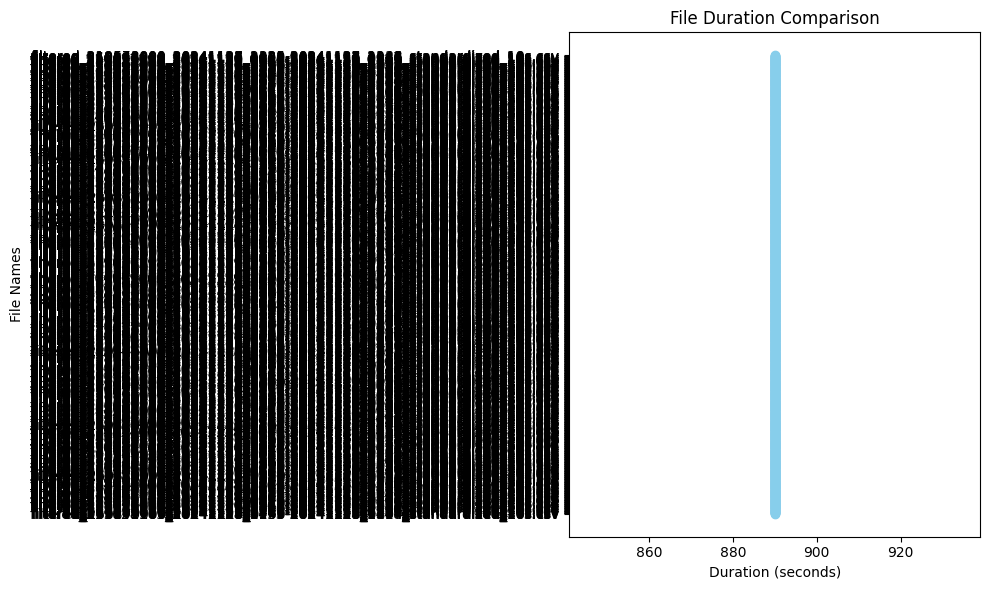

In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Specify the folder path where your CSV files are located
folder_path = './time_sets_standardized'

# Lists to store file names and their durations
file_names = []
durations = []

# Loop through all CSV files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)

        # Convert 'Timestamp' to datetime format
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])

        # Calculate the duration (time between first and last timestamp)
        time_diff = df['Timestamp'].max() - df['Timestamp'].min()

        # Append the file name and duration
        file_names.append(filename)
        durations.append(time_diff.total_seconds())  # Convert to seconds for easy comparison

# Scatter plot with durations on the x-axis
plt.figure(figsize=(10, 6))
plt.scatter(durations, file_names, color='skyblue')
plt.xlabel('Duration (seconds)')
plt.ylabel('File Names')
plt.title('File Duration Comparison')

# Show the plot
plt.tight_layout()
plt.show()


In [8]:
import os
import pandas as pd

def check_underway_sog(folder, sog_threshold):
    # Step 1: Get all CSV files in the specified folder
    csv_files = [f for f in os.listdir(folder) if f.endswith('.csv')]

    for csv_file in csv_files:
        file_path = os.path.join(folder, csv_file)
        try:
            # Step 2: Read the CSV file into a DataFrame
            df = pd.read_csv(file_path)

            # Step 3: Check if the navigational status is "Underway using engine" and SOG is above threshold
            if 'Navigational status' in df.columns and 'SOG' in df.columns:
                # Assuming there is only one row (vessel) per file, we directly check the condition
                navigational_status = df['Navigational status'].iloc[0]  # First row, first column value
                sog = df['SOG'].iloc[0]  # First row, first column value

                if navigational_status == 'Underway using engine' and sog > sog_threshold:
                    print(f"File {csv_file}: Vessel is 'Underway using engine' with SOG above {sog_threshold}")
            else:
                print(f"File {csv_file}: Missing required columns ('Navigational status' or 'SOG').")

        except Exception as e:
            print(f"Failed to process {csv_file}: {e}")

# Example usage:
folder = 'time_sets_st_shortened'  # Replace with your folder path
sog_threshold = 5.0  # Example threshold for SOG (e.g., 5 knots)

check_underway_sog(folder, sog_threshold)
